In [1]:
#Warnings Reduction

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional, SimpleRNN
from tensorflow.keras import Sequential
from tensorflow.keras.backend import clear_session
import pickle
import tensorflow_addons as tfa
from statistics import mean, median, quantiles
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve, auc
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix

ModuleNotFoundError: No module named 'tensorflow_addons'

### Funzioni

In [ ]:
def plot_model_metrics(data):
    '''
    Plot of training metrics
    '''
    fig = plt.figure(figsize=(16,12))
    sns.set_theme()

    plt.subplots_adjust(wspace=0.2, hspace = 0.3)
    plt.subplot(3,2,1)
    plt.plot(data['loss'], label = 'Train Loss')
    plt.plot(data['val_loss'], label = 'Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.xlabel('Epochs')

    plt.subplot(3,2,2)
    plt.plot(data['accuracy'], label = 'Train Accuracy')
    plt.plot(data['val_accuracy'], label = 'Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.xlabel('Epochs')

    plt.subplot(3,2,3)
    plt.plot(data['precision'], label = 'Train Precision')
    plt.plot(data['val_precision'], label = 'Validation Precision')
    plt.legend()
    plt.title('Precision')
    plt.xlabel('Epochs')

    plt.subplot(3,2,4)
    plt.plot(data['recall'], label = 'Train Recall')
    plt.plot(data['val_recall'], label = 'Validation Recall')
    plt.legend()
    plt.title('Recall')
    plt.xlabel('Epochs')

    plt.subplot(3,2,5)
    plt.plot(data['f1_macro'], label = 'Train F1 Score')
    plt.plot(data['val_f1_macro'], label = 'Validation F1 Score')
    plt.legend()
    plt.title('F1 Score (Macro)')
    plt.xlabel('Epochs')

    plt.subplot(3,2,6)
    plt.plot(data['f1_weighted'], label = 'Train F1 Score')
    plt.plot(data['val_f1_weighted'], label = 'Validation F1 Score')
    plt.legend()
    plt.title('F1 Score (Weighted)')
    plt.xlabel('Epochs')


In [ ]:
def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed.
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)

    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1

    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))


Bibliografia:

[Dealing with Imbalanced Data in TensorFlow: Class Weights](https://towardsdatascience.com/dealing-with-imbalanced-data-in-tensorflow-class-weights-60f876911f99)

In [ ]:
def evaluate_threshold(y_pred_raw, y_true):


    plt.figure(figsize=(10,8))
    plt.subplots_adjust(hspace = 0.3)
    for i in range(6):

        plt.subplot(3,3,i+1)
        plt.plot(np.where(y_true[:,i] == 0)[0], y_pred_raw[np.where(y_true[:,i] == 0)[0],i],'ro', alpha = 0.1)
        plt.plot(np.where(y_true[:,i] == 1)[0], y_pred_raw[np.where(y_true[:,i] == 1)[0],i],'go', alpha = 0.9)
        plt.title(f'Class {i}')


In [ ]:
def evaluate_model(y_true, y_pred, labels = ['0','1'], return_values = False):
    '''
    Print classification report and a confusion matrix for each label
    '''
    print('CLASSIFICATION REPORT: \n')
    print(classification_report(y_true, y_pred))

    cm = multilabel_confusion_matrix(y_true, y_pred)

    plt.figure(figsize = (12,12))
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
    for i in range(6):
        df_cm = pd.DataFrame(cm[i],
                            index = [labels[0],labels[1]],
                            columns = ['Predicted '+labels[0], 'Predicted '+labels[1]])
        plt.subplot(3,3,i+1)
        sns.heatmap(df_cm, annot = True, fmt = 'g')
        plt.title(f'Class: {i}')
        plt.suptitle('CONFUSION MATRIX')

In [ ]:
def evaluate_model_with_threshold(y_true, y_pred, y_pred_raw, labels = ['0','1'], th=[0.5,0.5,0.5,0.5,0.5,0.5], return_values = False):

    print(f'ACCURACY: {accuracy_score(y_true, y_pred)} \n')

    print('CLASSIFICATION REPORT: \n')
    print(classification_report(y_true, y_pred))

    cm = multilabel_confusion_matrix(y_true, y_pred)

    plt.figure(figsize = (20,20))
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
    sns.set_theme()
    for i in range(6):
        df_cm = pd.DataFrame(cm[i],
                            index = [labels[0],labels[1]],
                            columns = ['Predicted '+labels[0], 'Predicted '+labels[1]])
        plt.subplot(3,4,2*i+1)
        sns.heatmap(df_cm, annot = True, fmt = 'g')
        plt.title(f'Class: {i}')
        plt.subplot(3,4,2*i+2)
        plt.plot(np.where(y_true[:,i] == 0)[0], y_pred_raw[np.where(y_true[:,i] == 0)[0],i],'ro', alpha = 0.2, label = '0')
        plt.plot(np.where(y_true[:,i] == 1)[0], y_pred_raw[np.where(y_true[:,i] == 1)[0],i],'go', alpha = 0.9, label = '1')
        plt.hlines(y = th[i], xmin=0, xmax = y_true.shape[0]-1, label = 'Threshold', linestyles='dashed')
        plt.legend(loc = 'upper right', bbox_to_anchor = (1.05,1.2))
        plt.title(f'Class {i}')



In [ ]:
def get_prediction(y_pred_raw, th=[0.5,0.5,0.5,0.5,0.5,0.5]):

    label_0 = np.where(y_pred_raw[:,0] >= th[0], 1,0)
    label_1 = np.where(y_pred_raw[:,1] >= th[1], 1,0)
    label_2 = np.where(y_pred_raw[:,2] >= th[2], 1,0)
    label_3 = np.where(y_pred_raw[:,3] >= th[3], 1,0)
    label_4 = np.where(y_pred_raw[:,4] >= th[4], 1,0)
    label_5 = np.where(y_pred_raw[:,5] >= th[5], 1,0)

    return np.column_stack((label_0, label_1, label_2, label_3, label_4, label_5))

In [ ]:
def plot_precision_recall_curve(y_true, y_pred_raw):
  #Plot of the precision-recall curve with AUC
  plt.figure(figsize=(15,15))
  plt.subplots_adjust(wspace = 0.3, hspace = 0.2)
  best_thresholds = []
  best_F1 = []
  for i in range(6):


      precision, recall, thr = precision_recall_curve(y_true[:,i], y_pred_raw[:,i])
      auc_score = auc(recall, precision)
      f1_scores = 2*precision*recall/(precision + recall)
      ind = np.nanargmax(f1_scores)
      F1_max = np.nanmax(f1_scores)
      best_th = thr[ind-1]
      best_F1.append(F1_max)
      best_thresholds.append(best_th)

      plt.subplot(2,3,i+1)
      plt.plot(recall, precision)
      plt.plot(recall[ind], precision[ind], 'ro')
      plt.title(f'Class: {i}, AUC: {round(auc_score,3)}\nBest Th: {round(best_th, 4)}, Max F1: {round(F1_max, 3)}')
      plt.xlabel('Recall')
      plt.ylabel('Precision')
      plt.suptitle('Precision - Recall Curves')

  plt.show()

  return(best_thresholds, best_F1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
PATH_DRIVE = '/content/drive/MyDrive/MASTER DATA SCIENCE/7 - Deep Learning e Reti Neurali Artificiali/Progetto Filtro Anti-Hater per Social Network/'

In [ ]:
tf.config.list_physical_devices('GPU')

In [ ]:
tf.test.is_gpu_available()

### Import ed esplorazione del dataset

In [ ]:
df = pd.read_csv(PATH_DRIVE+'Filter_Toxic_Comments_dataset.csv')


In [ ]:
df.head()

comment_text  toxic  severe_toxic  \
0  Explanation\nWhy the edits made under my usern...      0             0   
1  D'aww! He matches this background colour I'm s...      0             0   
2  Hey man, I'm really not trying to edit war. It...      0             0   
3  "\nMore\nI can't make any real suggestions on ...      0             0   
4  You, sir, are my hero. Any chance you remember...      0             0   

   obscene  threat  insult  identity_hate  sum_injurious  
0        0       0       0              0              0  
1        0       0       0              0              0  
2        0       0       0              0              0  
3        0       0       0              0              0  
4        0       0       0              0              0

In [ ]:
df.shape

(159571, 8)

In totale sono presenti 159571 osservazioni.

In [ ]:
df.isna().sum()

comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
sum_injurious    0
dtype: int64

Si nota che non sono presenti NaN nel dataset.

In [ ]:
df[index].loc[5]

comment_text     "\n\nCongratulations from me as well, use the ...
toxic                                                            0
severe_toxic                                                     0
obscene                                                          0
threat                                                           0
insult                                                           0
identity_hate                                                    0
sum_injurious                                                    0
Name: 5, dtype: object

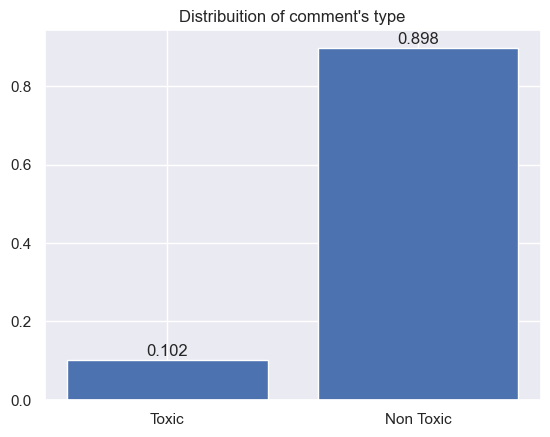

In [ ]:
sns.set_theme()

h_toxic = df[df.sum_injurious != 0].shape[0]/df.shape[0]
h_non_toxic = df[df.sum_injurious == 0].shape[0]/df.shape[0]

plt.bar( x = ['Toxic', 'Non Toxic'], height = [h_toxic, h_non_toxic])
plt.text('Toxic', h_toxic +0.01, str(round(h_toxic,3)), ha = 'center' )
plt.text('Non Toxic', h_non_toxic +0.01, str(round(h_non_toxic,3)), ha = 'center' )
plt.title("Distribuition of comment's type")
plt.show()

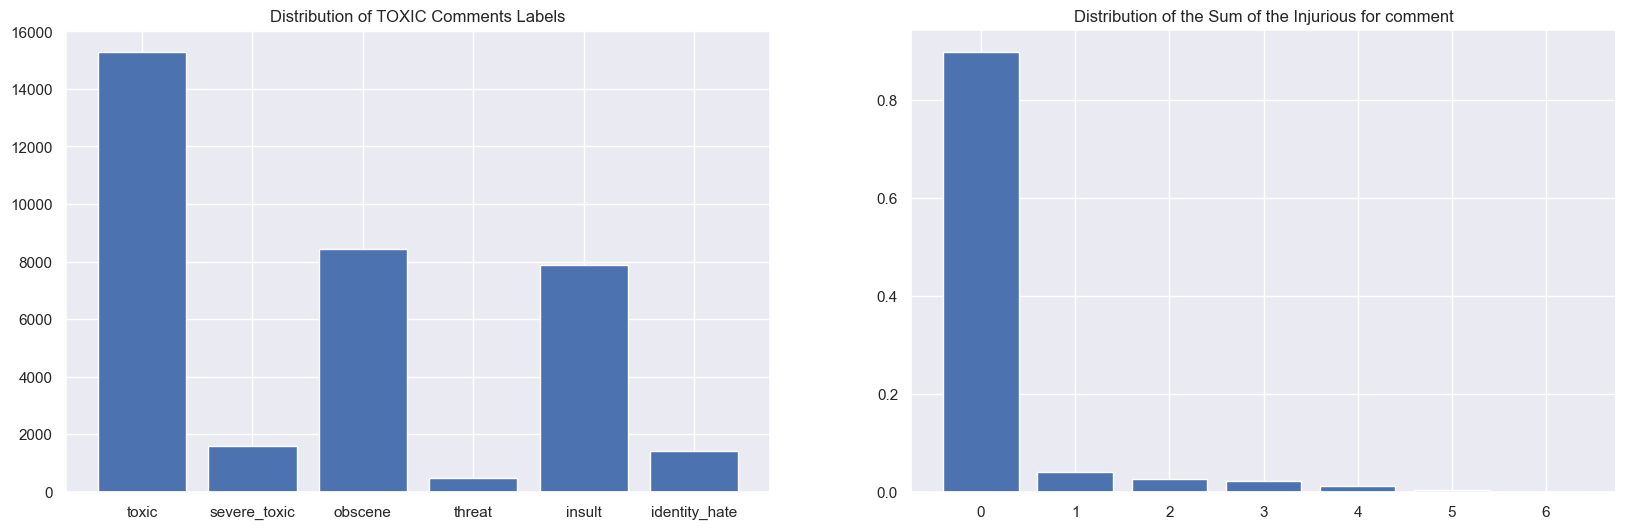

In [ ]:
plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
plt.bar(x = df.columns[1:7], height = df.iloc[:,range(1,7)].sum())
plt.title('Distribution of TOXIC Comments Labels')
plt.subplot(1,2,2)
plt.bar(x = np.arange(0,7), height = df.sum_injurious.value_counts(normalize = True))
plt.text('Non Toxic', h_non_toxic +0.01, str(round(h_non_toxic,3)), ha = 'center' )
plt.title('Distribution of the Sum of the Injurious for comment')
plt.show()

In [ ]:
df.iloc[:,range(1,7)].sum()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [ ]:
(df.iloc[:,range(1,7)].sum())/df.shape[0]

toxic            0.095844
severe_toxic     0.009996
obscene          0.052948
threat           0.002996
insult           0.049364
identity_hate    0.008805
dtype: float64

In [ ]:
df.sum_injurious.value_counts()

sum_injurious
0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: count, dtype: int64

In [ ]:
df.sum_injurious.value_counts(normalize = True)

sum_injurious
0    0.898321
1    0.039857
3    0.026377
2    0.021808
4    0.011030
5    0.002413
6    0.000194
Name: proportion, dtype: float64

Si osserva che quasi il 90% delle osservazioni non contiene commenti offensivi, tra questi il più diffuso è quello con con la label *toxic*, seguito da *obscene* e *insult*. Si nota che i commenti con 5 o più categorie d'offesa sono estramementi rari. Si tratta quindi di un dataset sbilanciato, usuale in questo tipo di problema.

### Preprocessing

In [ ]:
X = df.comment_text.values

Y = df.iloc[:,range(1,7)].values

In [ ]:
X.shape, Y.shape

((159571,), (159571, 6))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.05, random_state = 0)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=.05/0.95, random_state = 0)

In [ ]:
 X_train.shape, X_test.shape, X_val.shape

((143613,), (7979,), (7979,))

In [ ]:
 Y_train.shape, Y_test.shape, Y_val.shape

((143613, 6), (7979, 6), (7979, 6))

Si è deciso di impostare il parametro *num_words* a 10000 così da considerare solo le 9999 parole più frequenti.

In [ ]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)
val_sequences = tokenizer.texts_to_sequences(X_val)

In [ ]:
vocalubary_len = len(tokenizer.word_index)+1

In [ ]:
vocalubary_len

196856

In [ ]:
maxlen = len(max(train_sequences, key = len))
maxlen

1400

In [ ]:
len_seq = [len(x) for x in train_sequences]
mean_len = int(round(mean(len_seq),0))
median_len = median(len_seq)
mean_len, median_len

(64, 34)

La lunghezza massima delle sequenze del Training Set è di 1400 parole, quella media e mediana rispettivamente di 64 e 34 parole.

Si sono valutati i percentili della lunghezza delle sequenze per scegliere il valore di padding, così da individure un compromesso tra velocità di training e quantità di informazione contenuta nelle sequenze.

In [ ]:
quantiles(len_seq, n = 10)

[7.0, 13.0, 19.0, 26.0, 34.0, 45.0, 60.0, 86.0, 144.0]

Il 90° percentile è pari a 144 così si è deciso di adottare tale valore per il padding.

In [ ]:
len([i for i in len_seq if i == 0])

35

In [ ]:
len_seq = [len(x) for x in test_sequences]
len([i for i in len_seq if i == 0])

2

In [ ]:
len_seq = [len(x) for x in val_sequences]
len([i for i in len_seq if i == 0])

3

Si è notato che con il valore di *num_words* scelto pari a 10000, 35 osservazioni nel Training Set, 2 nel Test Set e 3 nel Validation Set avevano lunghezza nulla. Si è deciso di eliminare tali osservazioni.

In [ ]:
ind = [i for i in range(len(train_sequences)) if len(train_sequences[i]) < 1]
train_sequences = [x for x in train_sequences if len(x) >= 1]
Y_train = np.delete(Y_train, ind, axis = 0)

ind = [i for i in range(len(test_sequences)) if len(test_sequences[i]) < 1]
test_sequences = [x for x in test_sequences if len(x) >= 1]
Y_test = np.delete(Y_test, ind, axis = 0)

ind = [i for i in range(len(val_sequences)) if len(val_sequences[i]) < 1]
val_sequences = [x for x in val_sequences if len(x) >= 1]
Y_val = np.delete(Y_val, ind, axis = 0)


len(train_sequences), Y_train.shape, len(test_sequences), Y_test.shape, len(val_sequences), Y_val.shape

(143578, (143578, 6), 7977, (7977, 6), 7976, (7976, 6))

In [ ]:
max_words = 144

train_sequences_padded = pad_sequences(train_sequences, maxlen = max_words)
test_sequences_padded = pad_sequences(test_sequences, maxlen = max_words)
val_sequences_padded = pad_sequences(val_sequences, maxlen = max_words)

In [ ]:
train_sequences_padded.shape, test_sequences_padded.shape, val_sequences_padded.shape

((143578, 144), (7977, 144), (7976, 144))

In [ ]:
type(Y_train)

numpy.ndarray

In [ ]:
Y_train = Y_train.astype('float32')
Y_test = Y_test.astype('float32')
Y_val = Y_val.astype('float32')

train_sequences_padded = train_sequences_padded.astype('float32')
test_sequences_padded = test_sequences_padded.astype('float32')
val_sequences_padded = val_sequences_padded.astype('float32')

In [ ]:
index = np.random.choice(df.index,10)
for i in range(index.shape[0]):
    print(f'Comment:{i+1}')
    print(df.iloc[index[i],0])
    print('\n'+' * '*10+'\n')

Comment:1
Gwen. Factual accuracy - 'mostly' implies a majority, which is not the case. Besides, OpenFutureBoy or whatever the fuck he is called has been behaving like a dick and then getting all uppity when someone calls him on it - it's pretty pathetic to see. As for Wolfowitz, well, he's been getting up people's noses since the dawn of time. You'll note the numerical majority of my edits have been minor, but constructive. I'll continue on that path if you'd prefer. Unblock me, keep me blocked - it's not hugely important but it won't stop me from making little edits (which is what I prefer to do) and occasionally insulting dicks like OpenLegBoy (which someone needs to do). Your call.

 *  *  *  *  *  *  *  *  *  * 

Comment:2
REDIRECT Talk:D44 road (Croatia)

 *  *  *  *  *  *  *  *  *  * 

Comment:3
"

 Image:USTC building.jpg 

Assuming this building is still standing, then somebody could easily take a new photo of it and release it under a free license. We therefore cannot use this

In [ ]:
words_list = list(tokenizer.word_index.keys())[:9999]
len(words_list)

9999

In [ ]:
regex = r"[^a-zA-Z0-9'’´]"

index = []
words_strange = []
for i,word in enumerate(words_list):
    if re.search(regex, word) is not None:
        index.append(i)
        words_strange.append(word)

In [ ]:
len(words_strange)

39

In [ ]:
print(words_strange)

['•', '—', '–', '\xa0', '·', '”', '—preceding', '\u200e', '→', '\xa0talk', '☎', '♦', '“the', '←', '\xa0\xa0', '✉', '\xa0talk\xa0', '…', '—the', '—\xa0preceding', 'talk\xa0·', '—\xa0', '♣', '©', 'talk\xa0', '†', 'carrots→', '\xa0►\xa0', 'jéské', '§', '☼', '☺', 'talk•', '“', "—''''''", 'à', '“i', 'féin', '\xa0chat\xa0']


Esplorando il dataset, come nell'esempio mostrato sopra, si è notato che alcuni commenti contengono caratteri speciali, simboli o parole non in lingua inglese. Tuttavia, considerando che nell'istanza della classe *Tokenizer()* si è deciso di conisderare esclusivamente le 9999 parole più frequenti nel corpus di testo e, che durante la trasformazione vengono filtrati la maggior parte dei caratteri di punteggiatura e tabulazione, si è constatato che solo 39 parole del vocabolario utilizzato contengono caratteri particolari o simboli. Considerando che non è da escludere che questi possano essere presenti in pattern utili per classificare il testo, si è deciso di considerarli e non condurre altre operazioni di preprocessing.

### Modello

In [ ]:
metrics = [ 'accuracy',
            tf.metrics.Precision(thresholds=0.5),
            tf.metrics.Recall(thresholds=0.5),
            tfa.metrics.F1Score(num_classes = 6, average='macro',name = 'f1_macro', threshold = 0.5),
            tfa.metrics.F1Score(num_classes = 6, average='weighted',name = 'f1_weighted', threshold = 0.5)
           ]



#### Baseline Model: Simple RNN

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
tf.test.is_gpu_available()

True

Il primo modello testato è una semplice Vanilla RNN, costituita da:


*   Un layer di embedding con dimensione di output pari a 32
*   Un layer RNN di 64 neuroni
* Un output layer con funzione di attivazione sigmoide e 6 neuroni, uno per classe.

La scelta della configurazione dello strato di output è stata dettata dal problema, si tratta infatti di un problema di classificazione multi-label in cui le classi non sono mutuamente esclusive. Ogni neurone corrisponde a una classe e il suo valore di output, confrontato con una certa soglia(inizialmente pari a 0,5), determinerà se una certa osservazione apparterrà ad una classe oppure no.



In [ ]:
clear_session()

simple_RNN = Sequential()
simple_RNN.add(Embedding(input_dim = 10000, output_dim = 32, input_length = max_words))
simple_RNN.add(SimpleRNN(64, activation = 'tanh'))
simple_RNN.add(Dense(6, activation = 'sigmoid'))

simple_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 144, 32)           320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                6208      
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 326,598
Trainable params: 326,598
Non-trainable params: 0
_________________________________________________________________


La metrica che si è deciso di massimizzare durante l'allenamento è l'F1-score, la media armonica di precisione e recall. Infatti, si è ritenuto importante per il tipo di problema trattato raggiungere un buon compromesso tra precisione e recall.

In [ ]:
simple_RNN.compile(optimizer = 'rmsprop', loss= 'binary_crossentropy', metrics = metrics)

early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_f1_macro', mode = 'max', patience= 5)

hist_simple_RNN = simple_RNN.fit(train_sequences_padded,
                                 Y_train,
                                 batch_size = 128,
                                 callbacks = [early_stopper],
                                 epochs = 1000,
                                 validation_data = (val_sequences_padded, Y_val)
                                 )

simple_RNN.save('simple_RNN.h5')

with open('history_simple_RNN.pkl','wb') as file_pi:
  pickle.dump(hist_simple_RNN.history, file_pi)

Epoch 1/1000
1122/1122 [==============================] - 177s 156ms/step - loss: 0.1134 - accuracy: 0.9486 - precision: 0.5341 - recall: 0.3244 - f1_macro: 0.2582 - f1_weighted: 0.4118 - val_loss: 0.0715 - val_accuracy: 0.9951 - val_precision: 0.7489 - val_recall: 0.5483 - val_f1_macro: 0.3890 - val_f1_weighted: 0.6188
Epoch 2/1000
1122/1122 [==============================] - 177s 158ms/step - loss: 0.0685 - accuracy: 0.9935 - precision: 0.7430 - recall: 0.5547 - f1_macro: 0.3743 - f1_weighted: 0.6162 - val_loss: 0.0710 - val_accuracy: 0.9936 - val_precision: 0.8363 - val_recall: 0.4654 - val_f1_macro: 0.3260 - val_f1_weighted: 0.5788
Epoch 3/1000
1122/1122 [==============================] - 176s 157ms/step - loss: 0.0631 - accuracy: 0.9927 - precision: 0.7647 - recall: 0.5900 - f1_macro: 0.3766 - f1_weighted: 0.6422 - val_loss: 0.0664 - val_accuracy: 0.9949 - val_precision: 0.8511 - val_recall: 0.4989 - val_f1_macro: 0.3490 - val_f1_weighted: 0.6056
Epoch 4/1000
1122/1122 [==========

In [ ]:
simple_RNN.save('simple_RNN.h5')

with open('history_simple_RNN.pkl','wb') as file_pi:
  pickle.dump(hist_simple_RNN.history, file_pi)

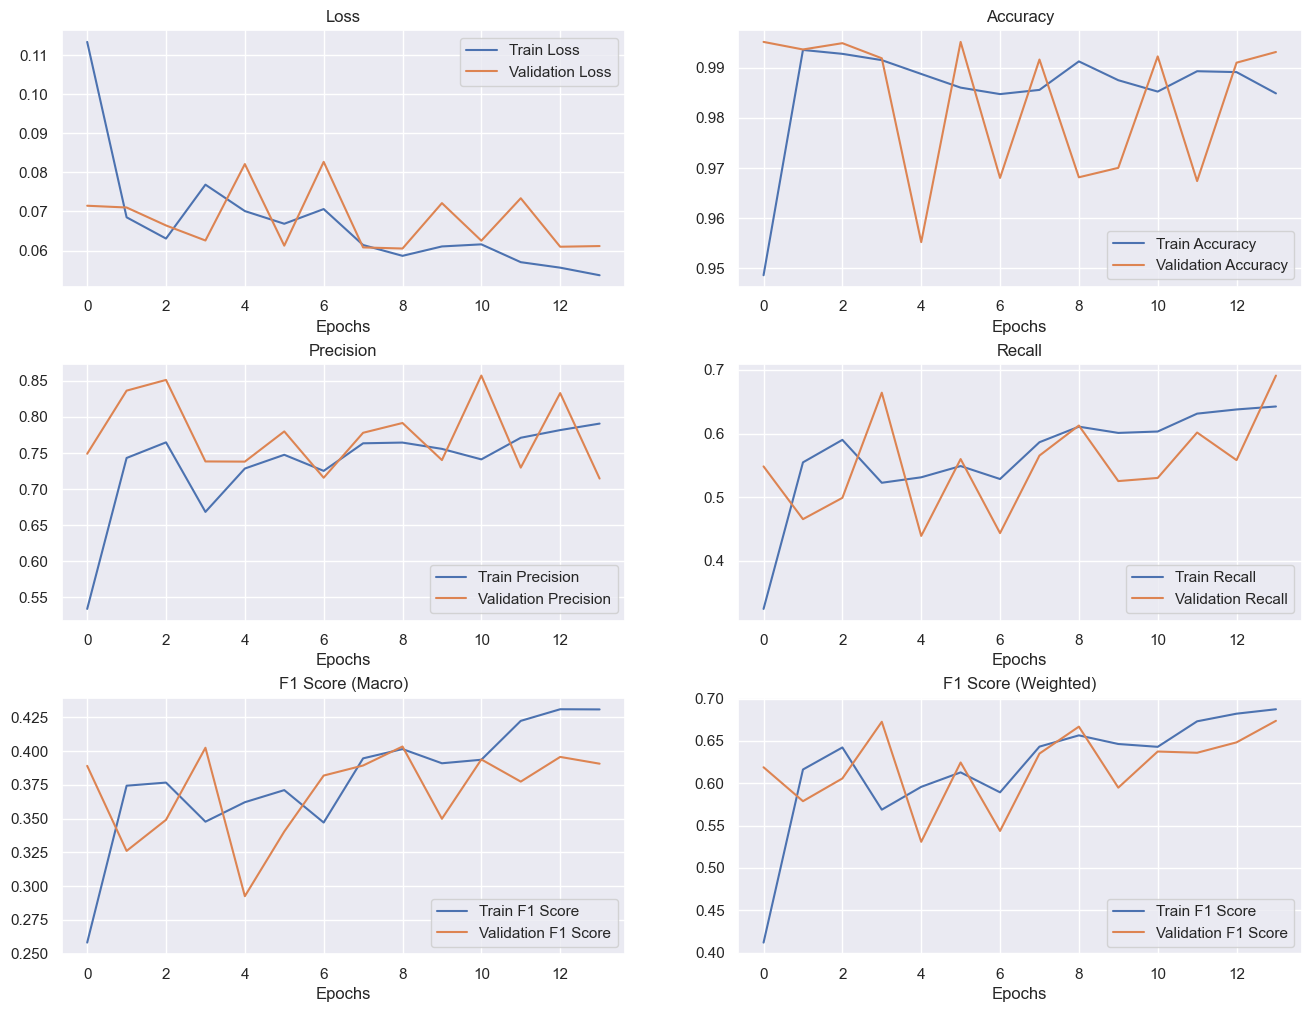

In [ ]:
with open('history_simple_RNN.pkl', 'rb') as file_pi:
    data = pickle.load(file_pi)
    plot_model_metrics(data)

Non è presente overfitting.

In [ ]:
simple_RNN = load_model(PATH_DRIVE + 'simple_RNN.h5')
y_pred_raw = simple_RNN.predict(val_sequences_padded)
y_pred_val = get_prediction(y_pred_raw)

250/250 [==============================] - 3s 12ms/step


Le prestazioni del modello sono state valutate mediante il classification report, riportante precisione, recall e e F1-score per ogni classe, in caso di dataset sbilanciato infatti l'accuratezza non rappresenta la metrica migliore.

Inoltre, per ogni classe è riportata la confusion matrix e un grafico con il valore di uscita dal neurone e il valore della soglia utilizzata per la classificazione(0,5 per tutte le classi). Il colore del marker di ogni osservazione indica l'appartenenza o meno a una determinata classe; idealmente, i due colori dovrebbero essere perfettamente separabili da una linea orizzontale il cui valore indica la soglia.

ACCURACY: 0.9059679037111334 

CLASSIFICATION REPORT: 

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       788
           1       0.33      0.02      0.04        83
           2       0.72      0.80      0.76       435
           3       0.00      0.00      0.00        21
           4       0.65      0.73      0.69       422
           5       0.36      0.05      0.10        73

   micro avg       0.71      0.69      0.70      1822
   macro avg       0.47      0.39      0.39      1822
weighted avg       0.68      0.69      0.67      1822
 samples avg       0.07      0.07      0.06      1822



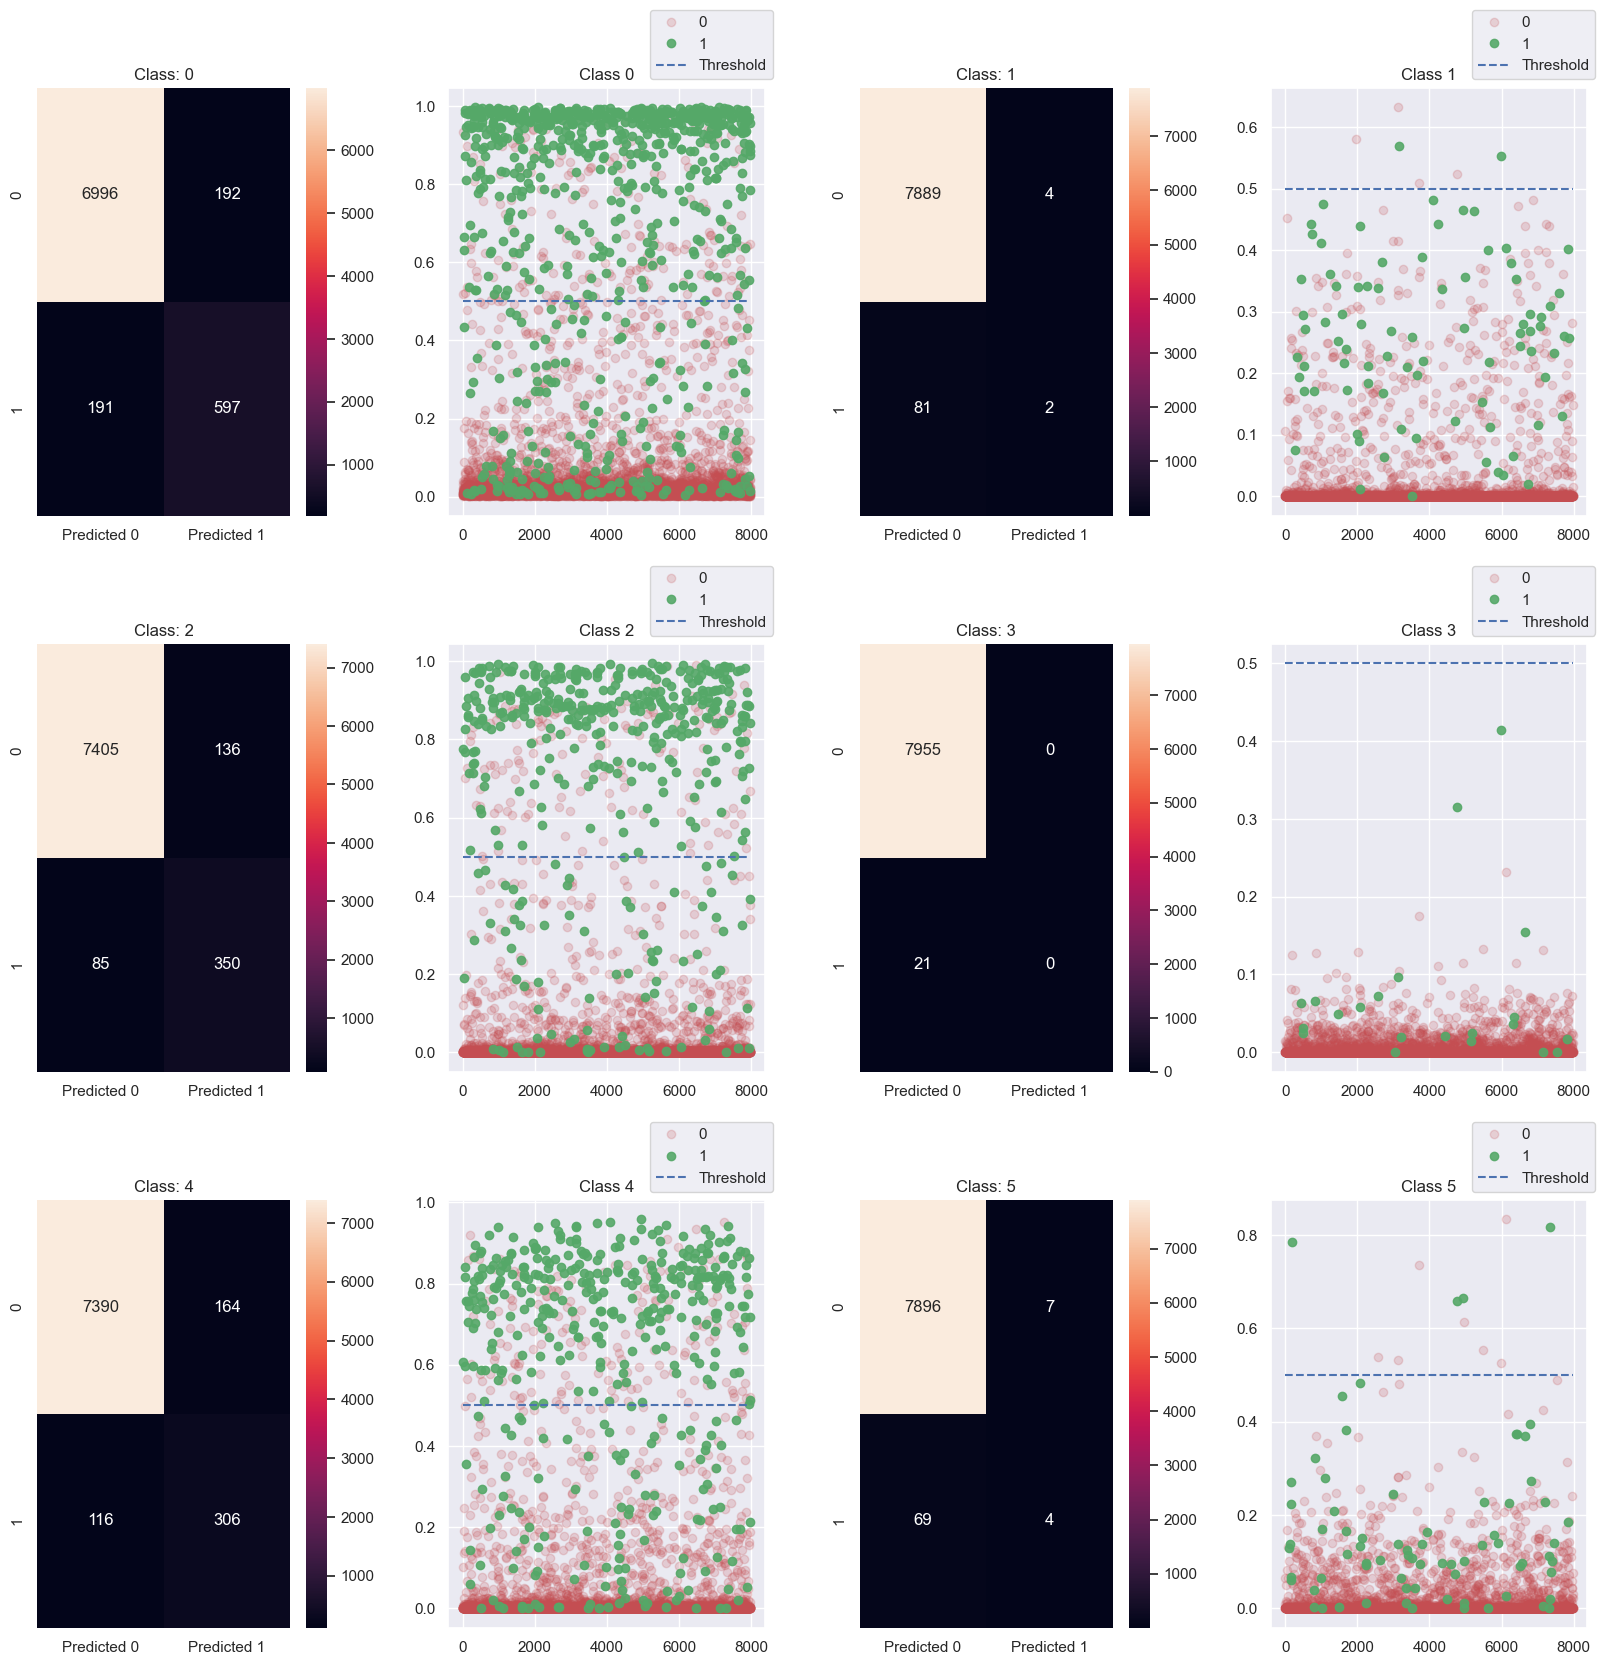

In [ ]:
evaluate_model_with_threshold(Y_val, y_pred_val, y_pred_raw)

Si nota come le prestazioni siano discrete per le classi con più osservazioni(0,2,4) e pessime per quelle con poche osservazioni con addirittura 0 predizioni corrette per la classe 3 e solo 4 su 73 per la classe 5.

Per cercare di ottimizzare la soglia di classificazione sono stati eseguti i grafici precisione-recall per diversi valori di soglia. Su tali grafici è riportato il valore della soglia che massimizza l'F1-score.

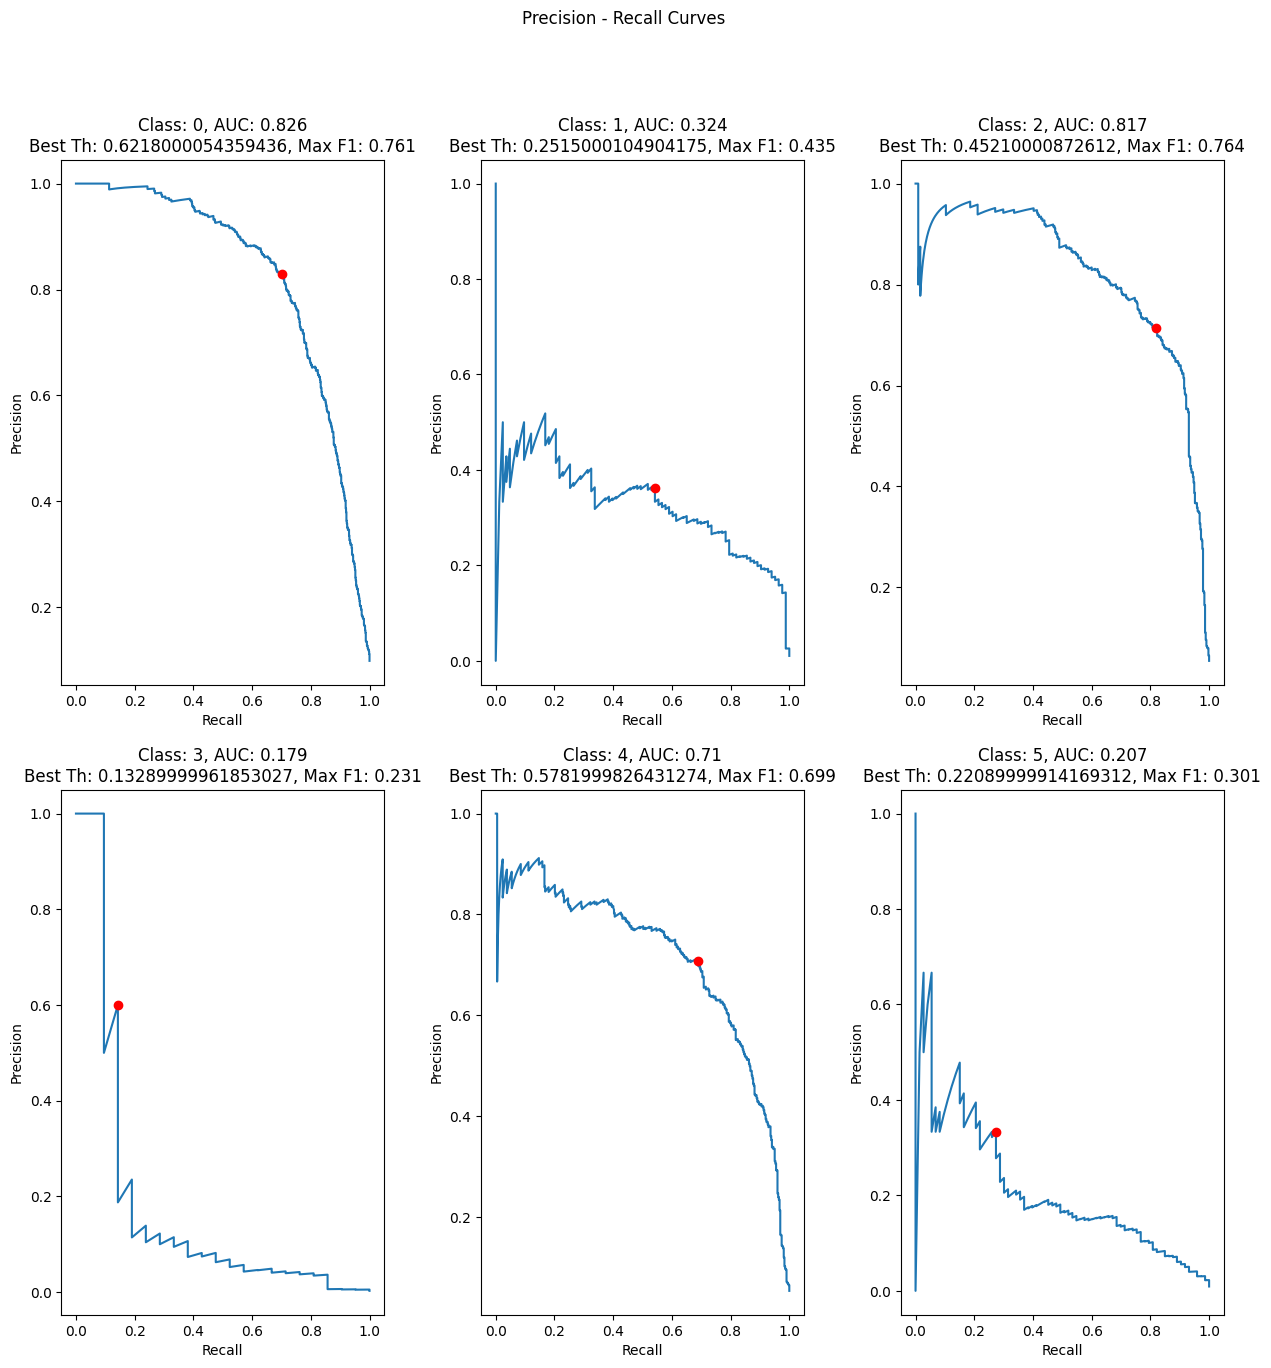

In [ ]:
best_th_simple_RNN, best_F1_simple_RNN = plot_precision_recall_curve(Y_val, y_pred_raw)

#### Simple RNN - Class weight

Visti gli scarsi risultati ottenuti sulle classi meno rappresentate si è provato ad utilizzare il parametro *class_weight* durante il training che consente di tenere conto dello sbilanciamente del dataset. L'architettura del modello è la stessa del precedente.

I parametri di valutazione del modello sono gli stessi descritti prima e anche in questo caso si è trovata la soglia che garantisse il massimo F1-score ottenibile sul Validation Set.

In [ ]:
clear_session()

simple_RNN_2 = Sequential()
simple_RNN_2.add(Embedding(input_dim = 10000, output_dim = 32, input_length = max_words))
simple_RNN_2.add(SimpleRNN(64, activation = 'tanh'))
simple_RNN_2.add(Dense(6, activation = 'sigmoid'))

simple_RNN_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 144, 32)           320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                6208      
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 326,598
Trainable params: 326,598
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class_weights = generate_class_weights(Y_train, multi_class=False, one_hot_encoded=True)
class_weights

{0: 1.741225836183269,
 1: 16.76921280074749,
 2: 3.1527887571365834,
 3: 54.38560606060606,
 4: 3.3913926681783826,
 5: 19.06746347941567}

In [ ]:
simple_RNN_2.compile(optimizer = 'rmsprop', loss= 'binary_crossentropy', metrics = metrics)

early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_f1_macro', mode = 'max', patience= 5)

hist_simple_RNN_2 = simple_RNN_2.fit(train_sequences_padded,
                                 Y_train,
                                 batch_size = 128,
                                 callbacks = [early_stopper],
                                 epochs = 1000,
                                 validation_data = (val_sequences_padded, Y_val),
                                 class_weight= class_weights
                                 )

simple_RNN_2.save('simple_RNN_2.h5')

with open('history_simple_RNN_2.pkl','wb') as file_pi:
  pickle.dump(hist_simple_RNN_2.history, file_pi)

Epoch 1/1000
1122/1122 [==============================] - 155s 138ms/step - loss: 0.2025 - accuracy: 0.9676 - precision: 0.6125 - recall: 0.3367 - f1_macro: 0.2806 - f1_weighted: 0.4407 - val_loss: 0.0666 - val_accuracy: 0.9951 - val_precision: 0.8114 - val_recall: 0.5170 - val_f1_macro: 0.3622 - val_f1_weighted: 0.6130
Epoch 2/1000
1122/1122 [==============================] - 153s 136ms/step - loss: 0.1458 - accuracy: 0.9902 - precision: 0.7477 - recall: 0.4980 - f1_macro: 0.3432 - f1_weighted: 0.5802 - val_loss: 0.0625 - val_accuracy: 0.9951 - val_precision: 0.8229 - val_recall: 0.5532 - val_f1_macro: 0.3490 - val_f1_weighted: 0.6345
Epoch 3/1000
1122/1122 [==============================] - 152s 135ms/step - loss: 0.1262 - accuracy: 0.9940 - precision: 0.7710 - recall: 0.5933 - f1_macro: 0.3642 - f1_weighted: 0.6431 - val_loss: 0.0595 - val_accuracy: 0.9951 - val_precision: 0.7277 - val_recall: 0.6718 - val_f1_macro: 0.3767 - val_f1_weighted: 0.6685
Epoch 4/1000
1122/1122 [==========

In [ ]:
simple_RNN_2.save('simple_RNN_2.h5')

with open('history_simple_RNN_2.pkl','wb') as file_pi:
  pickle.dump(hist_simple_RNN_2.history, file_pi)

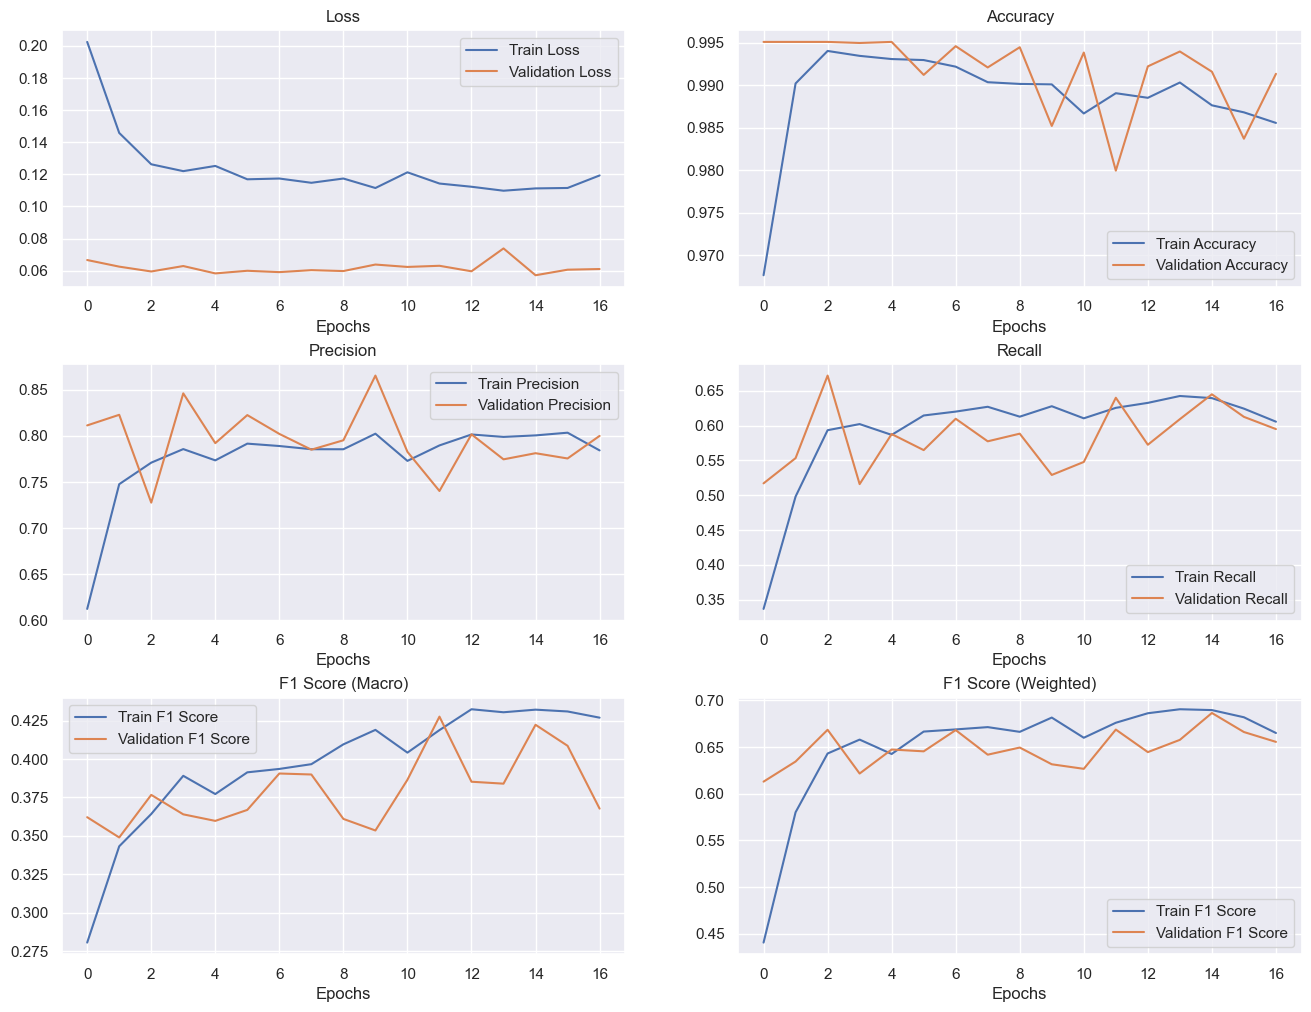

In [ ]:
with open('history_simple_RNN_2.pkl', 'rb') as file_pi:
    data = pickle.load(file_pi)
    plot_model_metrics(data)

In [ ]:
simple_RNN_2= load_model(PATH_DRIVE + 'simple_RNN_2.h5')
y_pred_raw = simple_RNN_2.predict(val_sequences_padded)
y_pred_val = get_prediction(y_pred_raw)

250/250 [==============================] - 4s 16ms/step


ACCURACY: 0.9131143430290872 

CLASSIFICATION REPORT: 

              precision    recall  f1-score   support

           0       0.85      0.65      0.74       788
           1       0.00      0.00      0.00        83
           2       0.81      0.72      0.76       435
           3       0.00      0.00      0.00        21
           4       0.73      0.60      0.66       422
           5       0.22      0.03      0.05        73

   micro avg       0.80      0.59      0.68      1822
   macro avg       0.43      0.33      0.37      1822
weighted avg       0.74      0.59      0.66      1822
 samples avg       0.06      0.05      0.05      1822



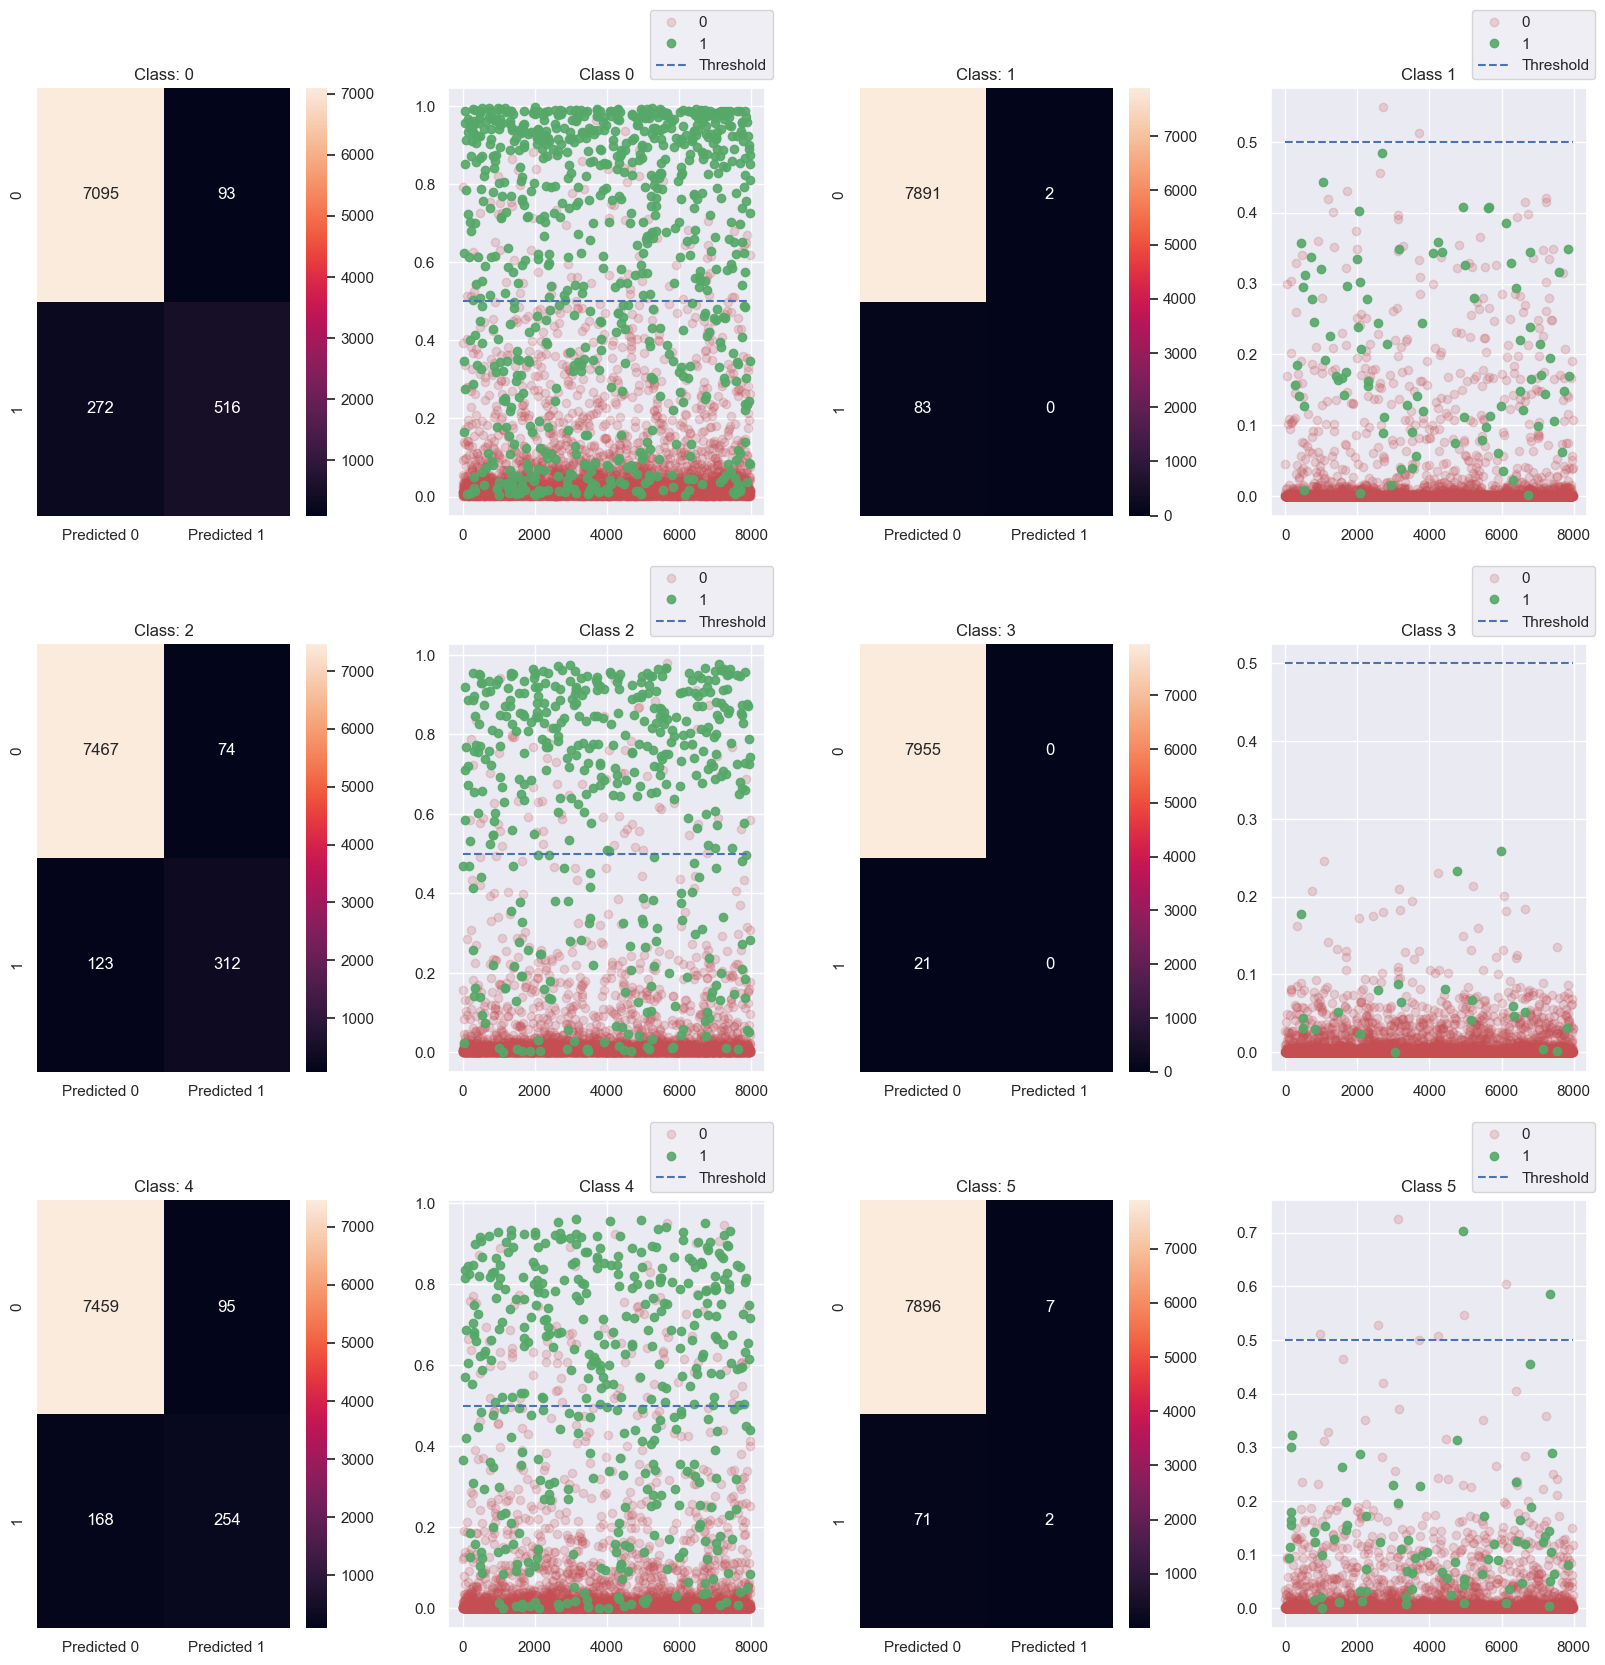

In [ ]:
evaluate_model_with_threshold(Y_val, y_pred_val, y_pred_raw)

In [ ]:
best_th_simple_RNN_2, best_F1_simple_RNN_2 = plot_precision_recall_curve(Y_val, y_pred_raw)

Le prestazioni, globalmente, non sembrano migliorare rispetto al modello allenato senza il parametro *class_weight*.

Per migliorare i risultati ottenuti sono stati testati altri tipi modelli con architettura pìù complessa. In particolare sono stati utilizzati i seguenti layer ricorrenti:


*   LSTM
*   Bidirectional LSTM

I metodi di valutaione delle prestazioni e di ottimizzazione delle soglie per la classificazione utilizzati sono gli stessi descritti in precedenza.


#### LSTM - NO Class weight

In questo modello il layer ricorrente semplice utillizzato nei due precedenti modelli è stato sostituito con un layer LSTM. Il resto della struttura della rete è invariato.

In [ ]:
clear_session()

LSTM_1 = Sequential()
LSTM_1.add(Embedding(input_dim = 10001, output_dim = 32, input_length = max_words))
LSTM_1.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5))
LSTM_1.add(Dense(6, activation = 'sigmoid'))

LSTM_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 144, 32)           320032    
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 345,254
Trainable params: 345,254
Non-trainable params: 0
_________________________________________________________________


In [ ]:
LSTM_1.compile(optimizer = 'rmsprop', loss= 'binary_crossentropy', metrics = metrics)

early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_f1_macro', mode = 'max', patience= 5)

hist_LSTM_1 = LSTM_1.fit(train_sequences_padded,
                             Y_train,
                             batch_size = 128,
                             callbacks = [early_stopper],
                             epochs = 1000,
                             validation_data = (val_sequences_padded, Y_val)
                            )

LSTM_1.save('/Models/LSTM_1.h5')

with open('/Models/history_LSTM_1.pkl', 'wb') as file_pi:
  pickle.dump(hist_LSTM_1.history, file_pi)

Epoch 1/1000
1122/1122 [==============================] - 700s 622ms/step - loss: 0.0853 - accuracy: 0.9911 - precision: 0.7707 - recall: 0.4078 - f1_macro: 0.3039 - f1_weighted: 0.5203 - val_loss: 0.0585 - val_accuracy: 0.9951 - val_precision: 0.7549 - val_recall: 0.7031 - val_f1_macro: 0.4021 - val_f1_weighted: 0.6967
Epoch 2/1000
1122/1122 [==============================] - 691s 616ms/step - loss: 0.0534 - accuracy: 0.9941 - precision: 0.8057 - recall: 0.6419 - f1_macro: 0.4122 - f1_weighted: 0.6899 - val_loss: 0.0532 - val_accuracy: 0.9951 - val_precision: 0.8017 - val_recall: 0.6745 - val_f1_macro: 0.4398 - val_f1_weighted: 0.7112
Epoch 3/1000
1122/1122 [==============================] - 697s 621ms/step - loss: 0.0504 - accuracy: 0.9939 - precision: 0.8167 - recall: 0.6566 - f1_macro: 0.4297 - f1_weighted: 0.7046 - val_loss: 0.0518 - val_accuracy: 0.9946 - val_precision: 0.8142 - val_recall: 0.6614 - val_f1_macro: 0.4466 - val_f1_weighted: 0.7102
Epoch 4/1000
1122/1122 [==========

In [ ]:
LSTM_1.save('LSTM_1.h5')

with open('history_LSTM_1.pkl', 'wb') as file_pi:
  pickle.dump(hist_LSTM_1.history, file_pi)

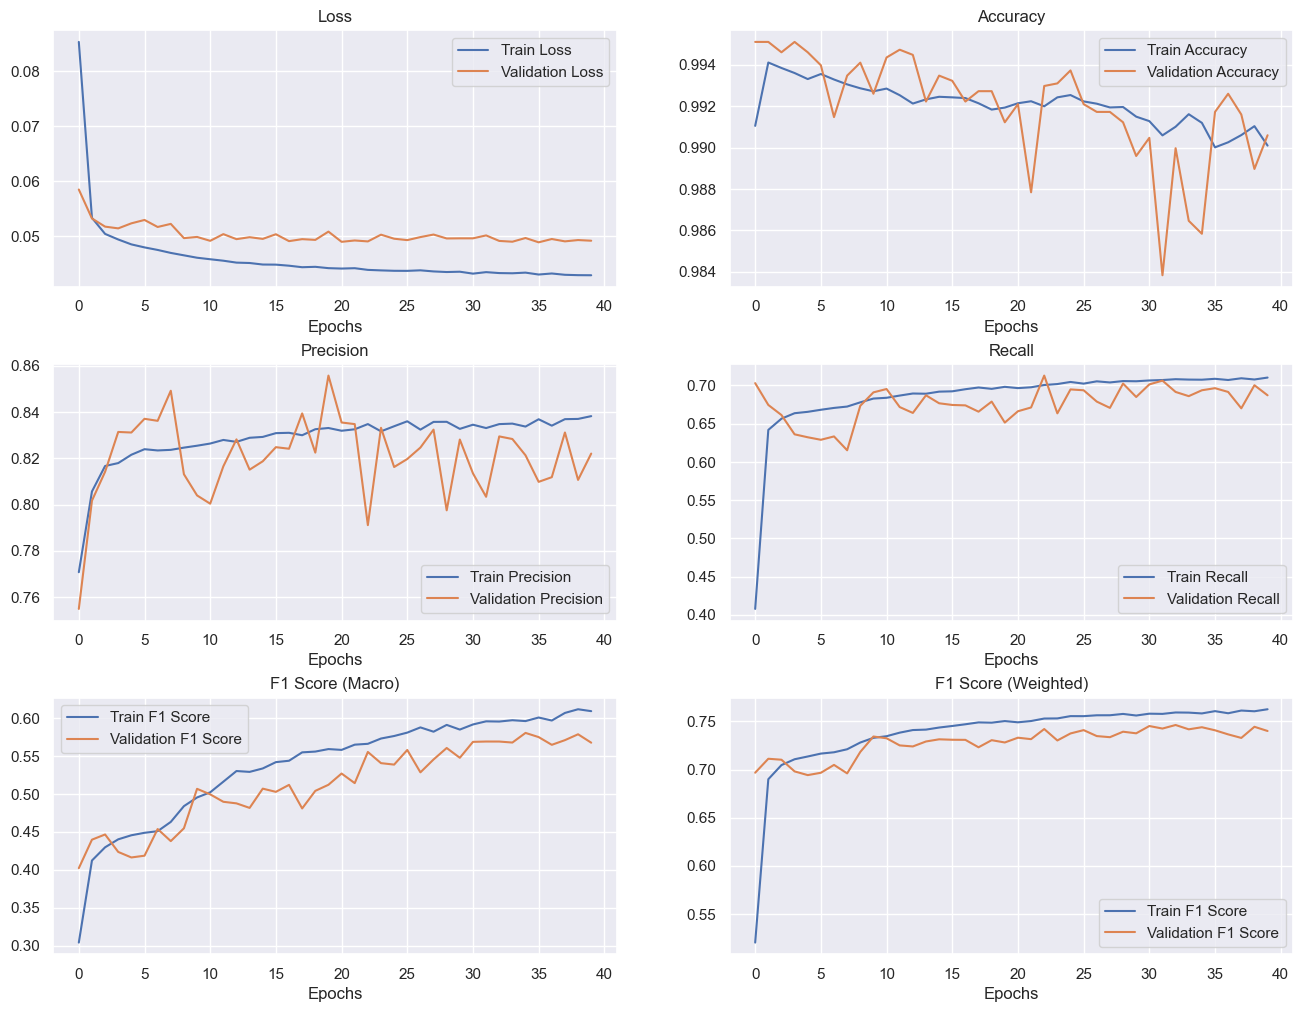

In [ ]:
with open('history_LSTM_1.pkl', 'rb') as file_pi:
    data = pickle.load(file_pi)
    plot_model_metrics(data)

Non è presente overfitting.

In [ ]:
LSTM_1 = load_model(PATH_DRIVE + 'LSTM_1.h5')
y_pred_raw = LSTM_1.predict(val_sequences_padded)
y_pred_val = get_prediction(y_pred_raw)

250/250 [==============================] - 15s 57ms/step


In [ ]:
evaluate_model_with_threshold(Y_val, y_pred_val, y_pred_raw)

ACCURACY: 0.9205115346038114 

CLASSIFICATION REPORT: 

              precision    recall  f1-score   support

           0       0.87      0.73      0.79       788
           1       0.45      0.20      0.28        83
           2       0.84      0.79      0.81       435
           3       0.62      0.24      0.34        21
           4       0.78      0.67      0.72       422
           5       0.66      0.34      0.45        73

   micro avg       0.82      0.69      0.75      1822
   macro avg       0.70      0.50      0.57      1822
weighted avg       0.81      0.69      0.74      1822
 samples avg       0.07      0.06      0.06      1822



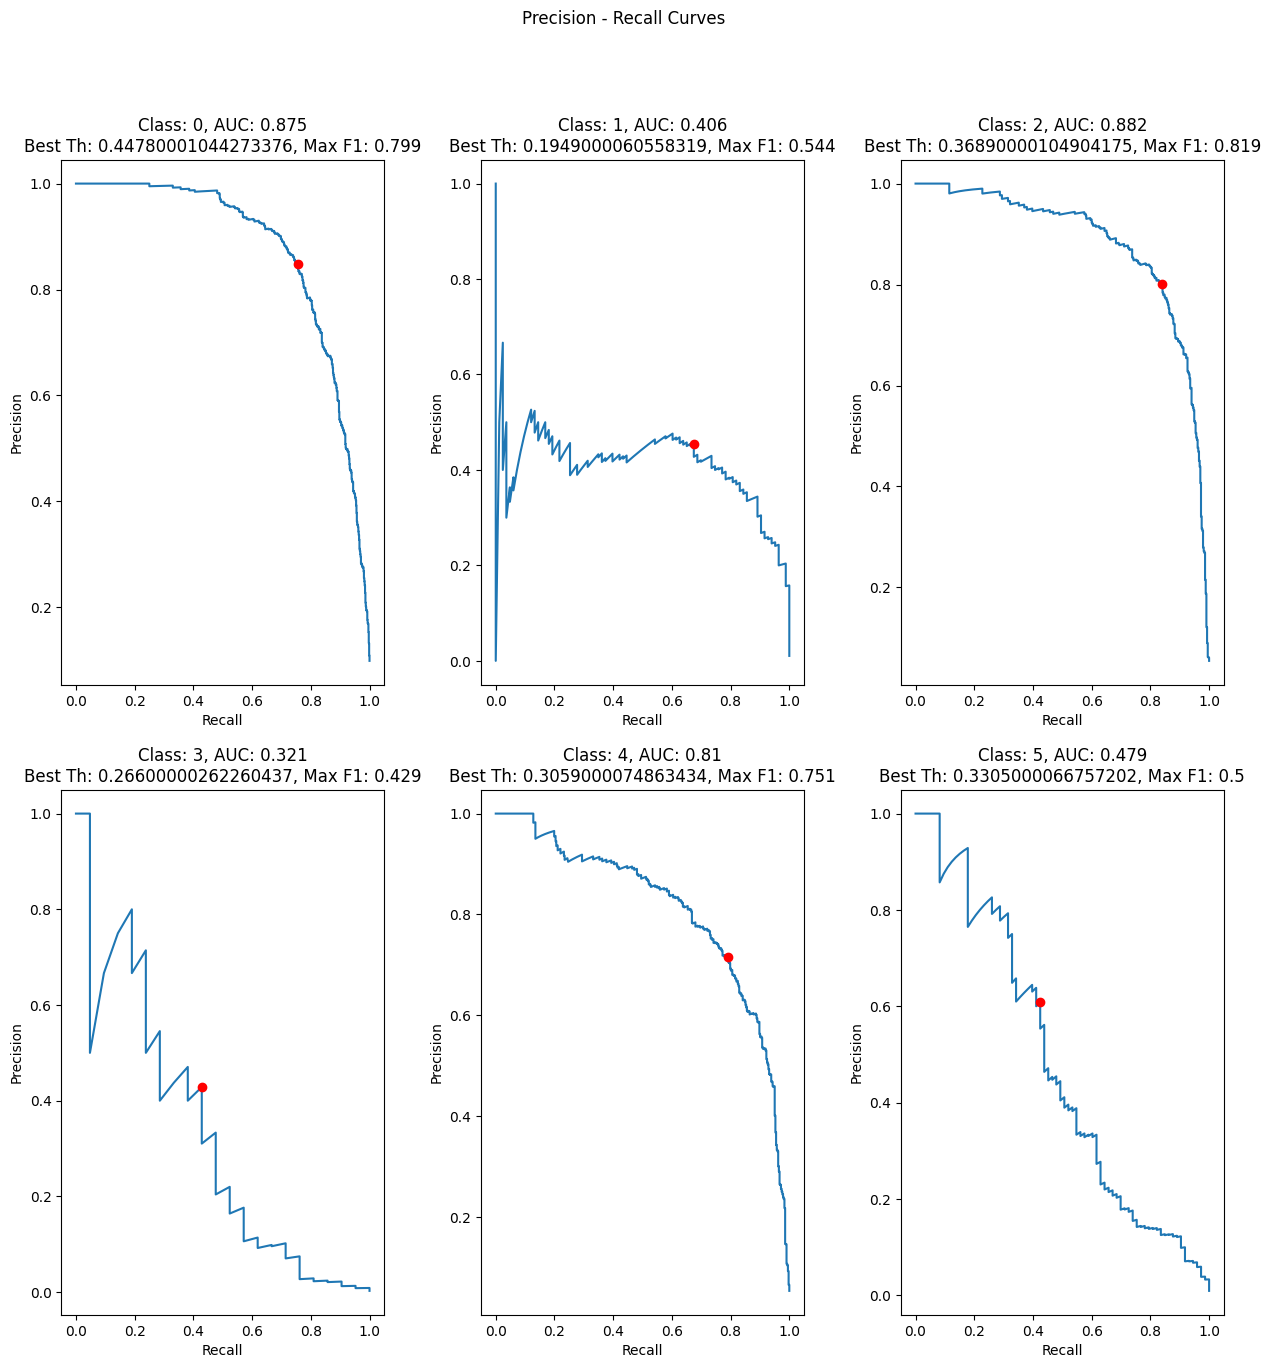

In [ ]:
best_th_LSTM_1, best_F1_LSTM_1 = plot_precision_recall_curve(Y_val, y_pred_raw)

Si osserva che le prestazioni migliorano, sopratutto in termini di precisione, per le classi con meno osservazioni (1,3,5) anche se non sono ancora del tutto soddisfacenti. Per tali classi migliora anche l'area sottesa alla curva precisione-recall, e con l'ottimizzazione delle soglie si riesce ad ottenere un miglior valore di F1-score per tali classi. I valori di F1-score per le altre classi sembrano non discostarsi particolarmente da quelli ottenuti in precedenza.

#### LSTM - Class weight

Anche in questo caso si è provato ad utilizzare il parametro *class_weight* durante l'allenamento per migliorare le prestazioni sulle classi meno rappresentate.

In [ ]:
clear_session()

LSTM_2 = Sequential()
LSTM_2.add(Embedding(input_dim = 10001, output_dim = 32, input_length = max_words))
LSTM_2.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5))
LSTM_2.add(Dense(6, activation = 'sigmoid'))

LSTM_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 144, 32)           320032    
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 345,254
Trainable params: 345,254
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class_weights = generate_class_weights(Y_train, multi_class=False, one_hot_encoded=True)
class_weights

{0: 1.741225836183269,
 1: 16.76921280074749,
 2: 3.1527887571365834,
 3: 54.38560606060606,
 4: 3.3913926681783826,
 5: 19.06746347941567}

In [ ]:
LSTM_2.compile(optimizer = 'rmsprop', loss= 'binary_crossentropy', metrics = metrics)

early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_f1_macro', mode = 'max', patience= 5)

hist_LSTM_2 = LSTM_2.fit(train_sequences_padded,
                             Y_train,
                             batch_size = 128,
                             callbacks = [early_stopper],
                             epochs = 1000,
                             validation_data = (val_sequences_padded, Y_val),
                             class_weight= class_weights
                            )

LSTM_2.save('LSTM_2.h5')

with open('LSTM_2.pkl', 'wb') as file_pi:
  pickle.dump(hist_LSTM_2.history, file_pi)

Epoch 1/1000
1122/1122 [==============================] - 691s 613ms/step - loss: 0.1682 - accuracy: 0.9902 - precision: 0.7814 - recall: 0.4091 - f1_macro: 0.3156 - f1_weighted: 0.5252 - val_loss: 0.0574 - val_accuracy: 0.9951 - val_precision: 0.8130 - val_recall: 0.6158 - val_f1_macro: 0.3800 - val_f1_weighted: 0.6722
Epoch 2/1000
1122/1122 [==============================] - 679s 605ms/step - loss: 0.1130 - accuracy: 0.9912 - precision: 0.8114 - recall: 0.6262 - f1_macro: 0.4061 - f1_weighted: 0.6826 - val_loss: 0.0544 - val_accuracy: 0.9951 - val_precision: 0.8440 - val_recall: 0.5911 - val_f1_macro: 0.4143 - val_f1_weighted: 0.6762
Epoch 3/1000
1122/1122 [==============================] - 684s 610ms/step - loss: 0.1072 - accuracy: 0.9926 - precision: 0.8187 - recall: 0.6472 - f1_macro: 0.4301 - f1_weighted: 0.7006 - val_loss: 0.0526 - val_accuracy: 0.9916 - val_precision: 0.8161 - val_recall: 0.6603 - val_f1_macro: 0.4519 - val_f1_weighted: 0.7113
Epoch 4/1000
1122/1122 [==========

In [ ]:
with open('history_LSTM_2.pkl', 'rb') as file_pi:
    data = pickle.load(file_pi)
    plot_model_metrics(data)

ACCURACY: 0.9196339017051154 

CLASSIFICATION REPORT: 

              precision    recall  f1-score   support

           0       0.90      0.67      0.77       788
           1       0.50      0.16      0.24        83
           2       0.85      0.77      0.81       435
           3       1.00      0.05      0.09        21
           4       0.81      0.60      0.69       422
           5       0.00      0.00      0.00        73

   micro avg       0.86      0.62      0.72      1822
   macro avg       0.68      0.37      0.43      1822
weighted avg       0.82      0.62      0.70      1822
 samples avg       0.06      0.06      0.06      1822



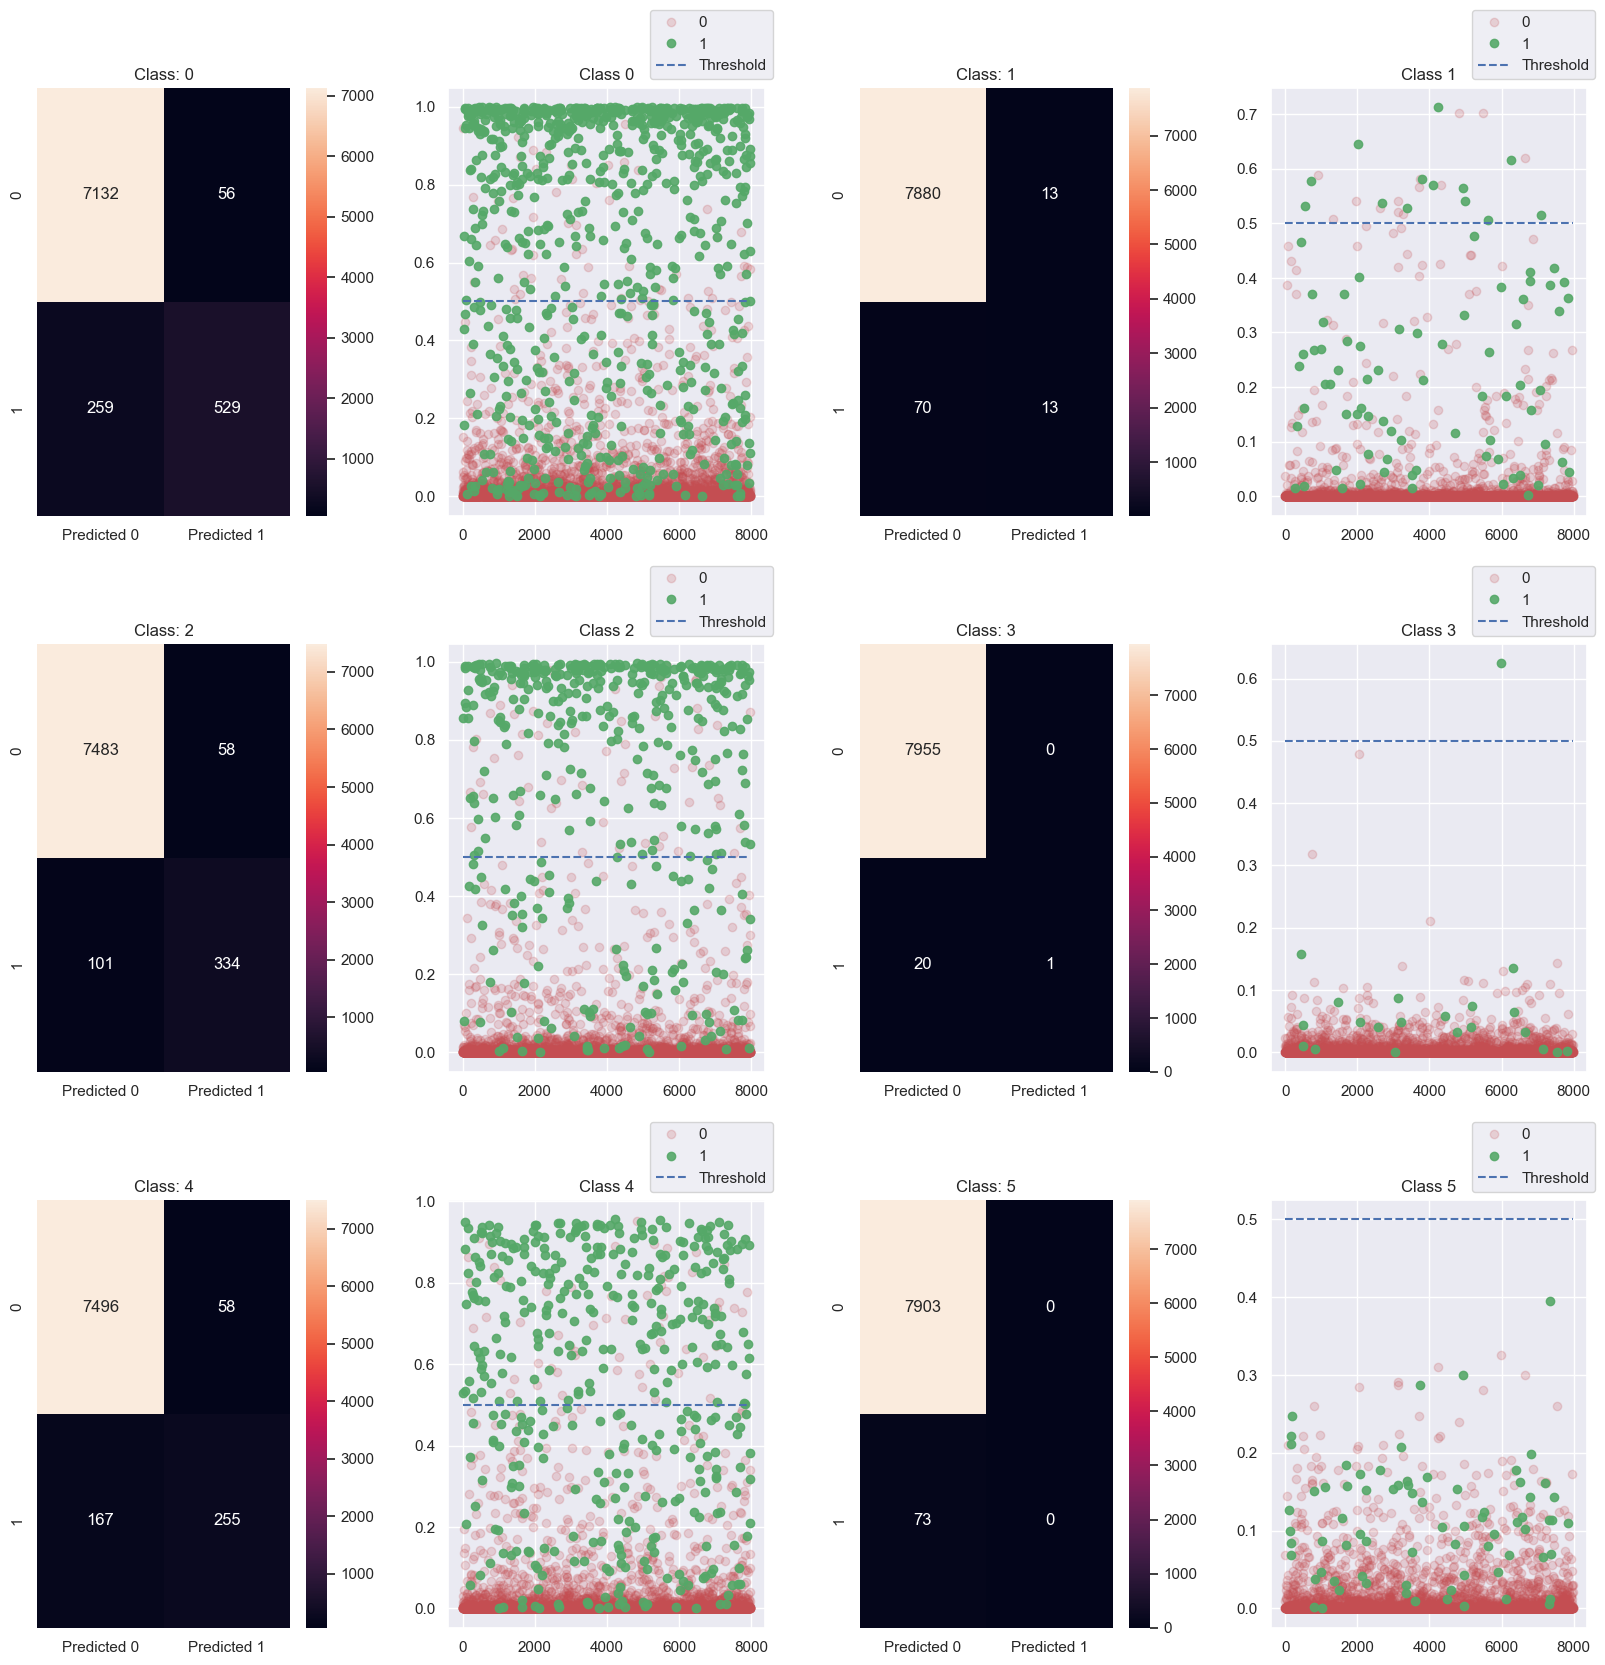

In [ ]:
evaluate_model_with_threshold(Y_val, y_pred_val, y_pred_raw)

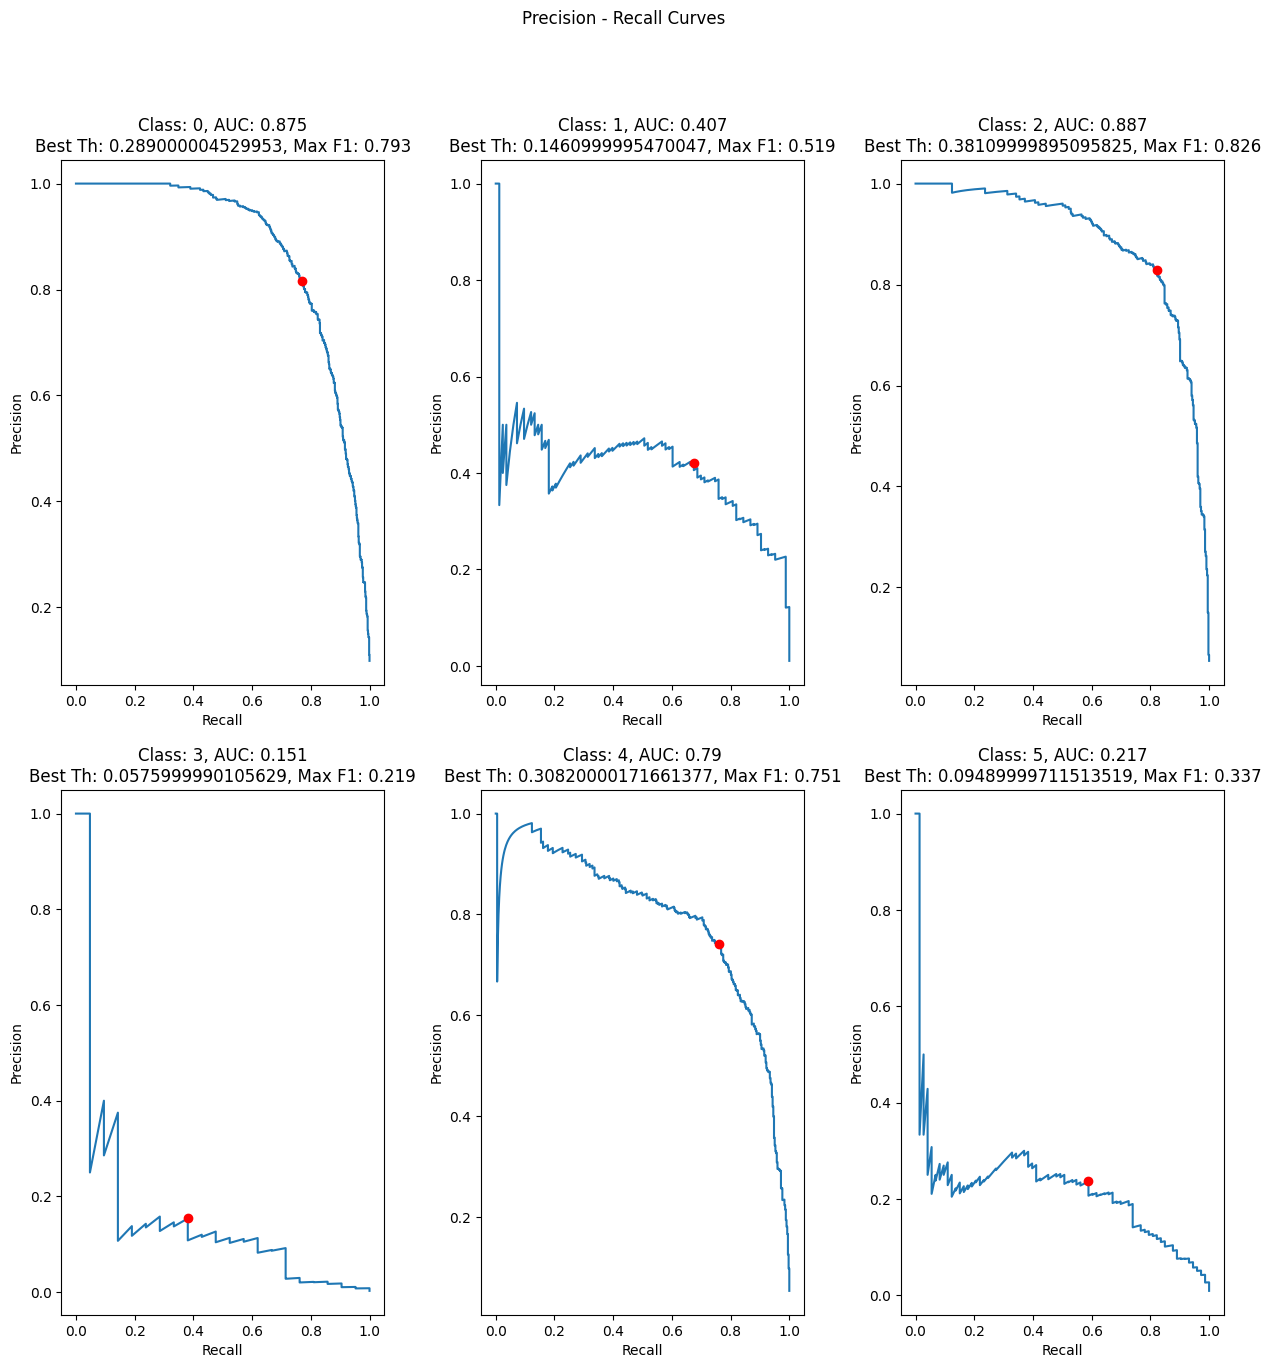

In [ ]:
best_th_LSTM_2, best_F1_LSTM_2 = plot_precision_recall_curve(Y_val, y_pred_raw)

Come nel caso del modello con layer ricorrente semplice non ci sono miglioramenti rispetto al modello allenato senza l'utilizzzo del parametro *class_weight*, anzi le prestazioni sembrano essere peggiori.

#### 2 Bidirectional LSTM - NO Class weight

L'architettura di questo modello è la più complessa tra quelle testate, infatti, il semplice layer ricorrente del primo modello è stato sostituito da due layer LSTM bidirezionali. Anche in questo caso il layer di embedding e quello di output hanno lo stessa configurazione del primo modello.

In [ ]:
clear_session()

biLSTM_1 = Sequential()
biLSTM_1.add(Embedding(input_dim = 10001, output_dim = 32, input_length = max_words))
biLSTM_1.add(Bidirectional(LSTM(64, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
biLSTM_1.add(Bidirectional(LSTM(64, dropout=0.5, recurrent_dropout=0.5)))
biLSTM_1.add(Dense(6, activation = 'sigmoid'))

biLSTM_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 144, 32)           320032    
                                                                 
 bidirectional (Bidirectiona  (None, 144, 128)         49664     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 469,286
Trainable params: 469,286
Non-trainable params: 0
_________________________________________________________________


In [ ]:
LSTM_2 = load_model(PATH_DRIVE + 'LSTM_2.h5')

y_pred_raw = LSTM_2.predict(val_sequences_padded)
y_pred_val = get_prediction(y_pred_raw)

250/250 [==============================] - 14s 54ms/step


In [ ]:
biLSTM_1.compile(optimizer = 'rmsprop', loss= 'binary_crossentropy', metrics = metrics)

early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_f1_macro', mode = 'max', patience= 5)

hist_biLSTM_1 = biLSTM_1.fit(train_sequences_padded,
                             Y_train,
                             batch_size = 128,
                             callbacks = [early_stopper],
                             epochs = 1000,
                             validation_data = (val_sequences_padded, Y_val)
                            )

biLSTM_1.save('biLSTM_1.h5')

with open('history_biLSTM_1.pkl', 'wb') as file_pi:
  pickle.dump(hist_biLSTM_1.history, file_pi)

Epoch 1/1000
1122/1122 [==============================] - 2749s 2s/step - loss: 0.0809 - accuracy: 0.9901 - precision: 0.7501 - recall: 0.4698 - f1_macro: 0.3309 - f1_weighted: 0.5614 - val_loss: 0.0552 - val_accuracy: 0.9951 - val_precision: 0.7899 - val_recall: 0.6581 - val_f1_macro: 0.3976 - val_f1_weighted: 0.6895
Epoch 2/1000
1122/1122 [==============================] - 2771s 2s/step - loss: 0.0533 - accuracy: 0.9938 - precision: 0.8090 - recall: 0.6352 - f1_macro: 0.4044 - f1_weighted: 0.6859 - val_loss: 0.0549 - val_accuracy: 0.9951 - val_precision: 0.8584 - val_recall: 0.5922 - val_f1_macro: 0.3675 - val_f1_weighted: 0.6715
Epoch 3/1000
1122/1122 [==============================] - 2721s 2s/step - loss: 0.0503 - accuracy: 0.9938 - precision: 0.8165 - recall: 0.6528 - f1_macro: 0.4183 - f1_weighted: 0.7007 - val_loss: 0.0517 - val_accuracy: 0.9950 - val_precision: 0.8306 - val_recall: 0.6432 - val_f1_macro: 0.4117 - val_f1_weighted: 0.7001
Epoch 4/1000
1122/1122 [================

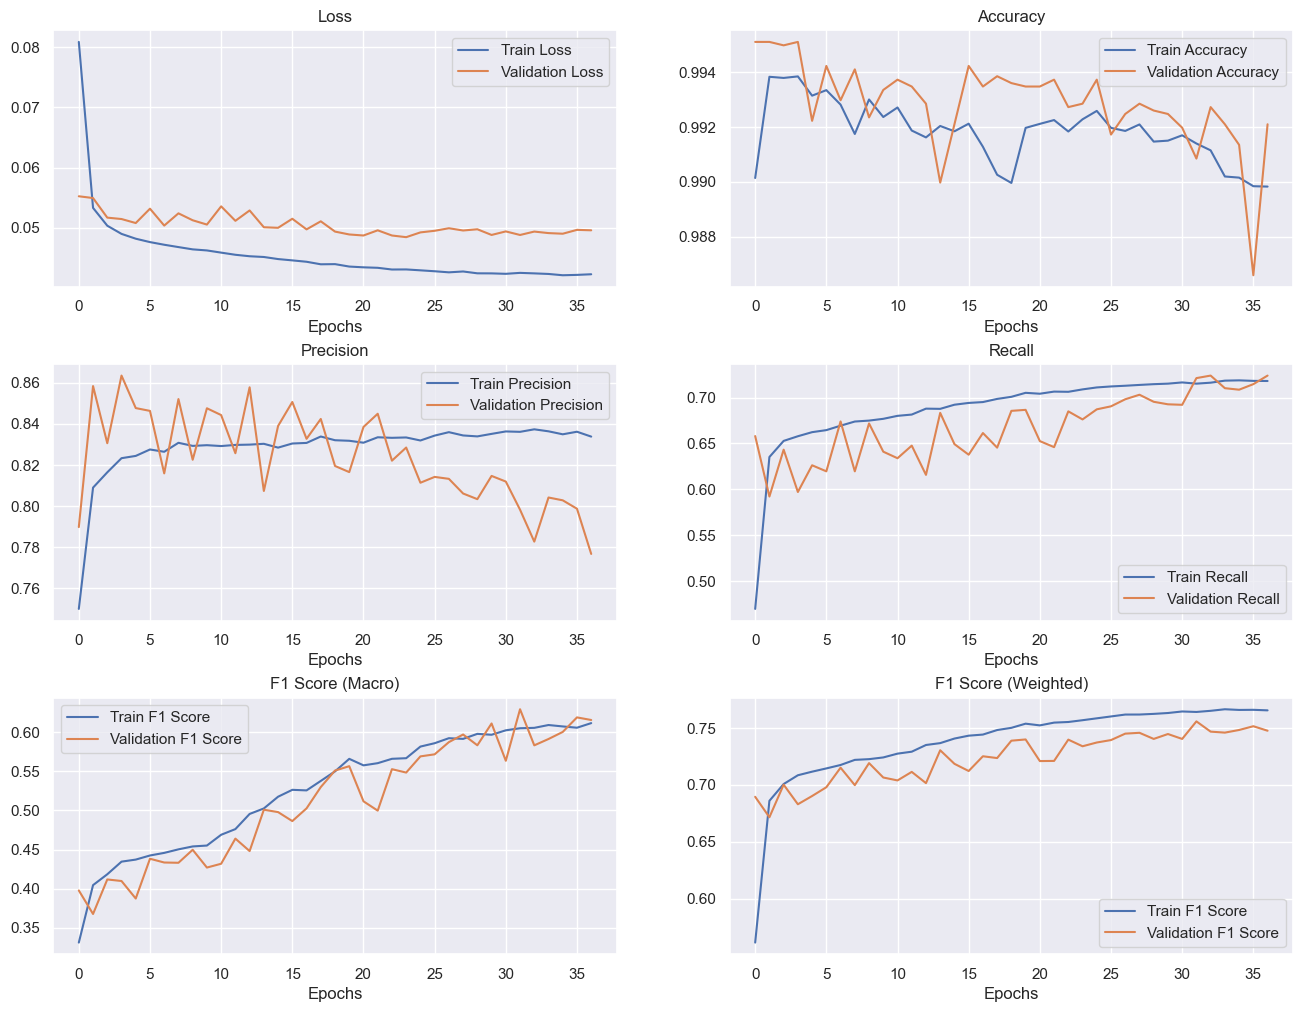

In [ ]:
with open('history_biLSTM_1.pkl', 'rb') as file_pi:
    data = pickle.load(file_pi)
    plot_model_metrics(data)

Non è presente overfitting.

In [ ]:
biLSTM_1 = load_model(PATH_DRIVE + 'biLSTM_1.h5')

In [ ]:
y_pred_raw = biLSTM_1.predict(val_sequences_padded)
y_pred_val = get_prediction(y_pred_raw)

250/250 [==============================] - 44s 174ms/step


ACCURACY: 0.9167502507522568 

CLASSIFICATION REPORT: 

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       788
           1       0.46      0.41      0.43        83
           2       0.81      0.77      0.79       435
           3       0.47      0.38      0.42        21
           4       0.74      0.74      0.74       422
           5       0.66      0.42      0.52        73

   micro avg       0.78      0.72      0.75      1822
   macro avg       0.66      0.58      0.62      1822
weighted avg       0.77      0.72      0.75      1822
 samples avg       0.07      0.07      0.06      1822



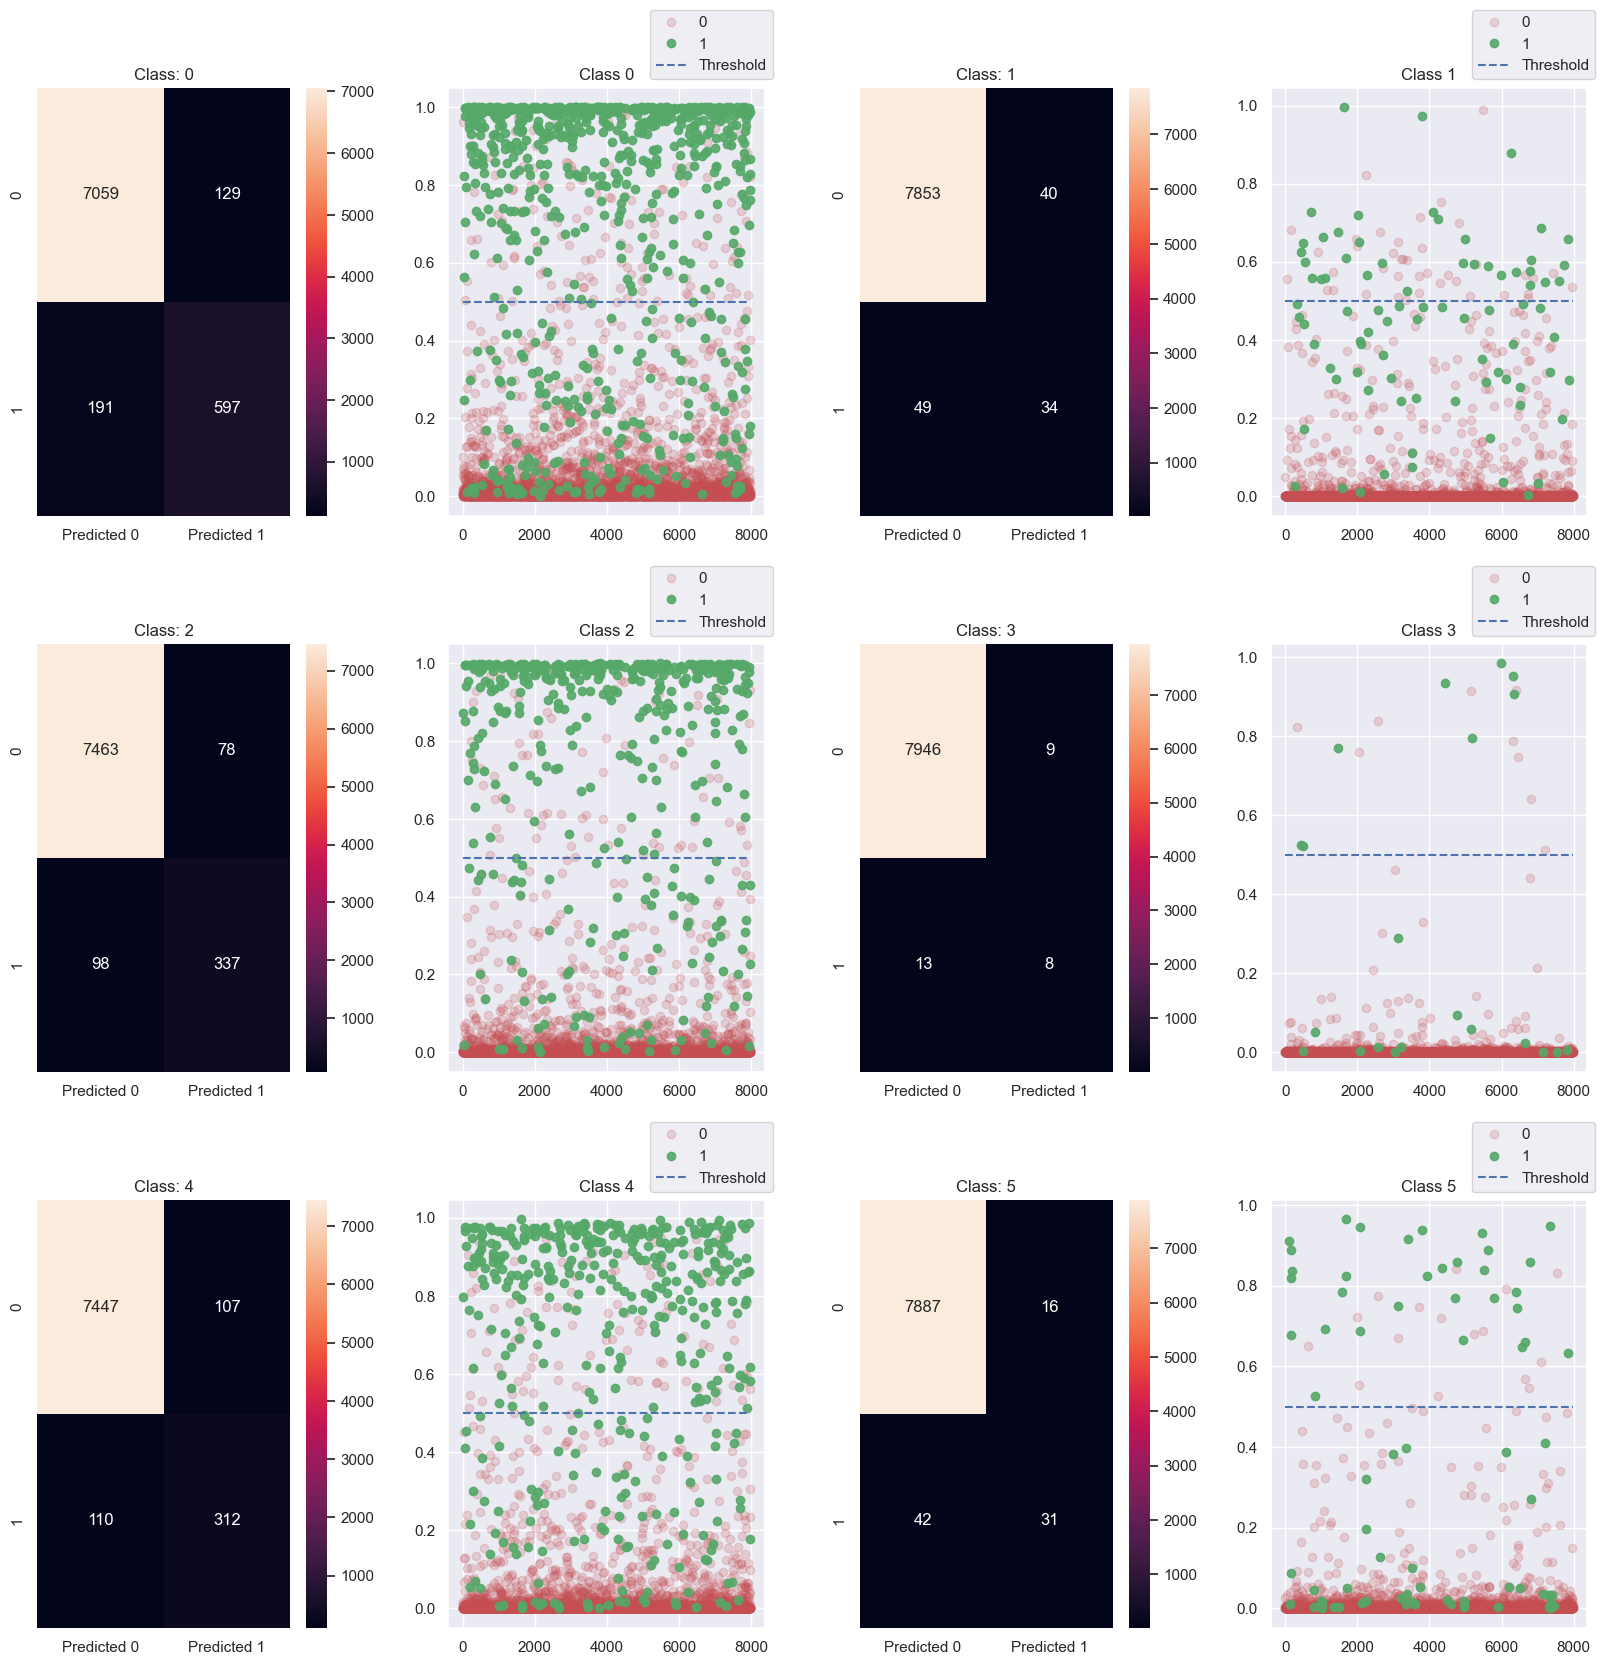

In [ ]:
evaluate_model_with_threshold(Y_val, y_pred_val, y_pred_raw)

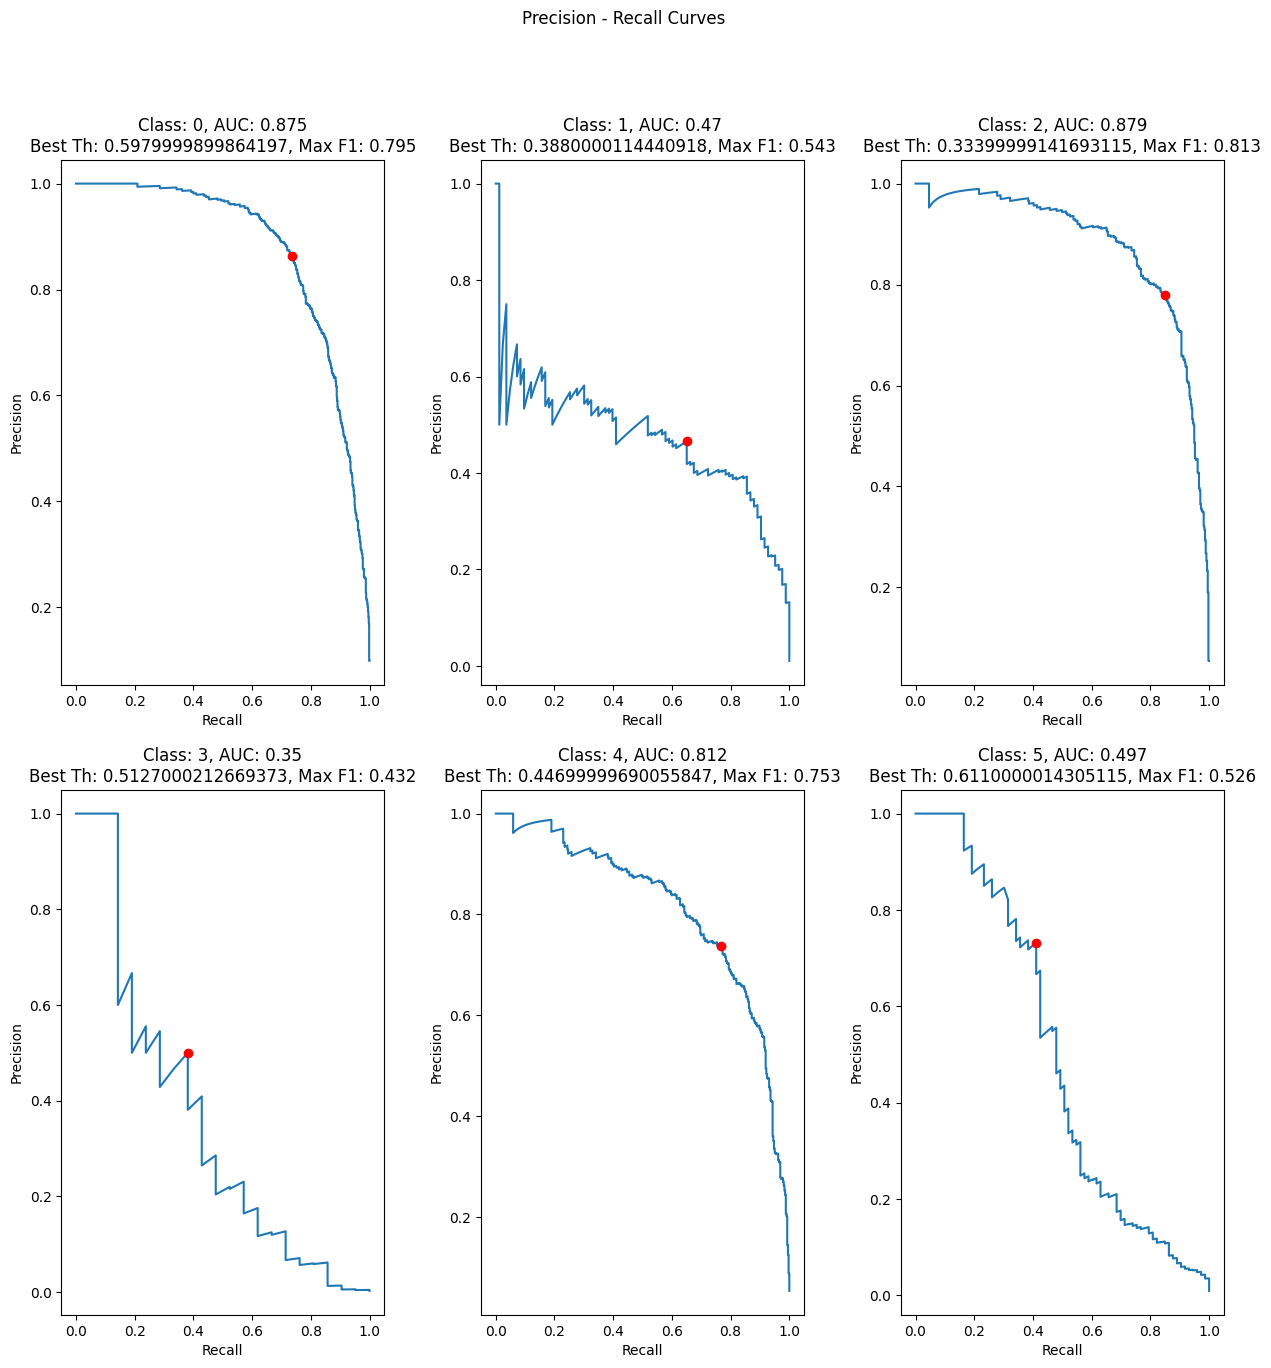

In [ ]:
best_th_biLSTM_1, best_F1_biLSTM_1 = plot_precision_recall_curve(Y_val, y_pred_raw)

Anche in questo caso le prestazioni migliorano rispetto al modello più semplice in termini di precisione e recall, soprattutto per le classi meno rappresentate. Questo si riflette in un sensibile aumento dell'F1-score con macro average. Il training di questo modello ha richiesto molto tempo, considerando che l'introduzione del parametro *class weight* finora non ha prodotto significativi miglioramenti delle performance, si è deciso di non allenare per questa  architettura la variante con tale parametro.

### Confronto dei modelli

I modelli sono stati confrontati paragonando i risultati ottenuti sul Validation Set considerando l'F1-score, visto che si è deciso di massimizzare tale metrica.

In particolare, si è valutato l'F1 score globale, utilizzando la macro average (media degli F1-score di ciascuna classe) e la weighted average (media pesata degli F1-score di ogni classe).

Inoltre, sono stati confrontati i valori di F1-score per ogni classe ottenuti da ciascun modello.

In [ ]:
f1_score_macro = []
f1_score_weighted = []
f1_score_0 = []
f1_score_1 = []
f1_score_2 = []
f1_score_3 = []
f1_score_4 = []
f1_score_5 = []

dict_add = classification_report(Y_val, get_prediction(simple_RNN.predict(val_sequences_padded), th = best_th_simple_RNN), output_dict = True)
f1_score_macro.append(dict_add['macro avg']['f1-score'])
f1_score_weighted.append(dict_add['weighted avg']['f1-score'])
f1_score_0.append(dict_add['0']['f1-score'])
f1_score_1.append(dict_add['1']['f1-score'])
f1_score_2.append(dict_add['2']['f1-score'])
f1_score_3.append(dict_add['3']['f1-score'])
f1_score_4.append(dict_add['4']['f1-score'])
f1_score_5.append(dict_add['5']['f1-score'])

dict_add = classification_report(Y_val, get_prediction(simple_RNN_2.predict(val_sequences_padded), th = best_th_simple_RNN_2), output_dict = True)
f1_score_macro.append(dict_add['macro avg']['f1-score'])
f1_score_weighted.append(dict_add['weighted avg']['f1-score'])
f1_score_0.append(dict_add['0']['f1-score'])
f1_score_1.append(dict_add['1']['f1-score'])
f1_score_2.append(dict_add['2']['f1-score'])
f1_score_3.append(dict_add['3']['f1-score'])
f1_score_4.append(dict_add['4']['f1-score'])
f1_score_5.append(dict_add['5']['f1-score'])

dict_add = classification_report(Y_val, get_prediction(LSTM_1.predict(val_sequences_padded), th = best_th_LSTM_1), output_dict = True)
f1_score_macro.append(dict_add['macro avg']['f1-score'])
f1_score_weighted.append(dict_add['weighted avg']['f1-score'])
f1_score_0.append(dict_add['0']['f1-score'])
f1_score_1.append(dict_add['1']['f1-score'])
f1_score_2.append(dict_add['2']['f1-score'])
f1_score_3.append(dict_add['3']['f1-score'])
f1_score_4.append(dict_add['4']['f1-score'])
f1_score_5.append(dict_add['5']['f1-score'])

dict_add = classification_report(Y_val, get_prediction(LSTM_2.predict(val_sequences_padded), th = best_th_LSTM_2), output_dict = True)
f1_score_macro.append(dict_add['macro avg']['f1-score'])
f1_score_weighted.append(dict_add['weighted avg']['f1-score'])
f1_score_0.append(dict_add['0']['f1-score'])
f1_score_1.append(dict_add['1']['f1-score'])
f1_score_2.append(dict_add['2']['f1-score'])
f1_score_3.append(dict_add['3']['f1-score'])
f1_score_4.append(dict_add['4']['f1-score'])
f1_score_5.append(dict_add['5']['f1-score'])

dict_add = classification_report(Y_val, get_prediction(biLSTM_1.predict(val_sequences_padded), th = best_th_biLSTM_1), output_dict = True)
f1_score_macro.append(dict_add['macro avg']['f1-score'])
f1_score_weighted.append(dict_add['weighted avg']['f1-score'])
f1_score_0.append(dict_add['0']['f1-score'])
f1_score_1.append(dict_add['1']['f1-score'])
f1_score_2.append(dict_add['2']['f1-score'])
f1_score_3.append(dict_add['3']['f1-score'])
f1_score_4.append(dict_add['4']['f1-score'])
f1_score_5.append(dict_add['5']['f1-score'])

250/250 [==============================] - 42s 168ms/step


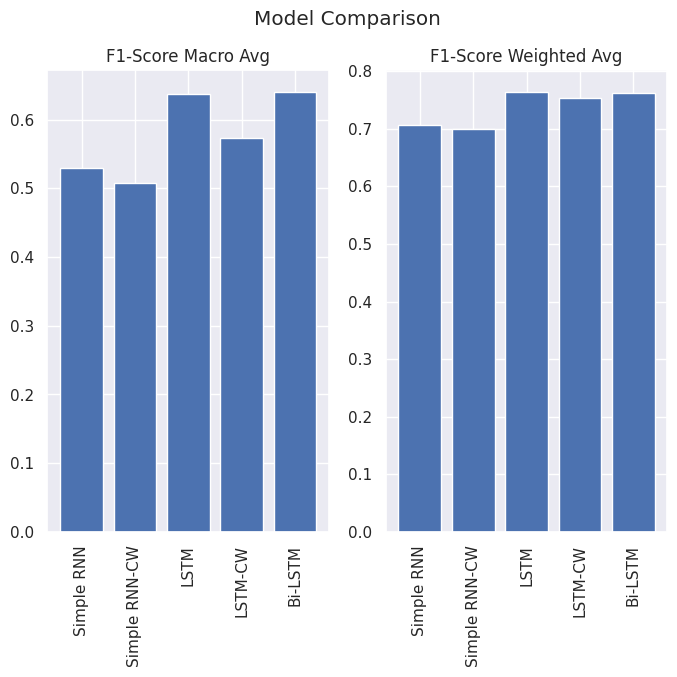

In [ ]:
models = ['Simple RNN', 'Simple RNN-CW', 'LSTM', 'LSTM-CW', 'Bi-LSTM']

plt.figure(figsize = (8,6))
sns.set_theme()
plt.subplot(1,2,1)
plt.bar(x = models, height=f1_score_macro)
plt.xticks(rotation = 90)
plt.title('F1-Score Macro Avg')
plt.subplot(1,2,2)
plt.bar(x = models, height=f1_score_weighted)
plt.xticks(rotation = 90)
plt.title('F1-Score Weighted Avg')
plt.suptitle('Model Comparison')
plt.show()

Si nota che i modelli LSTM e Bidirectional LSTM (Bi-LSTM) raggiungono le migliori performance sia in termini di F1-score Macro avg che F1-score weighted avg. Inoltre. si osserva che per i modelli con Class Weight (CW) si ottengono risultati peggiori rispetto ai corrispettivi in cui tale parametro non è stato utilizzato, a conferma di quanto notato nella precedente sezione.

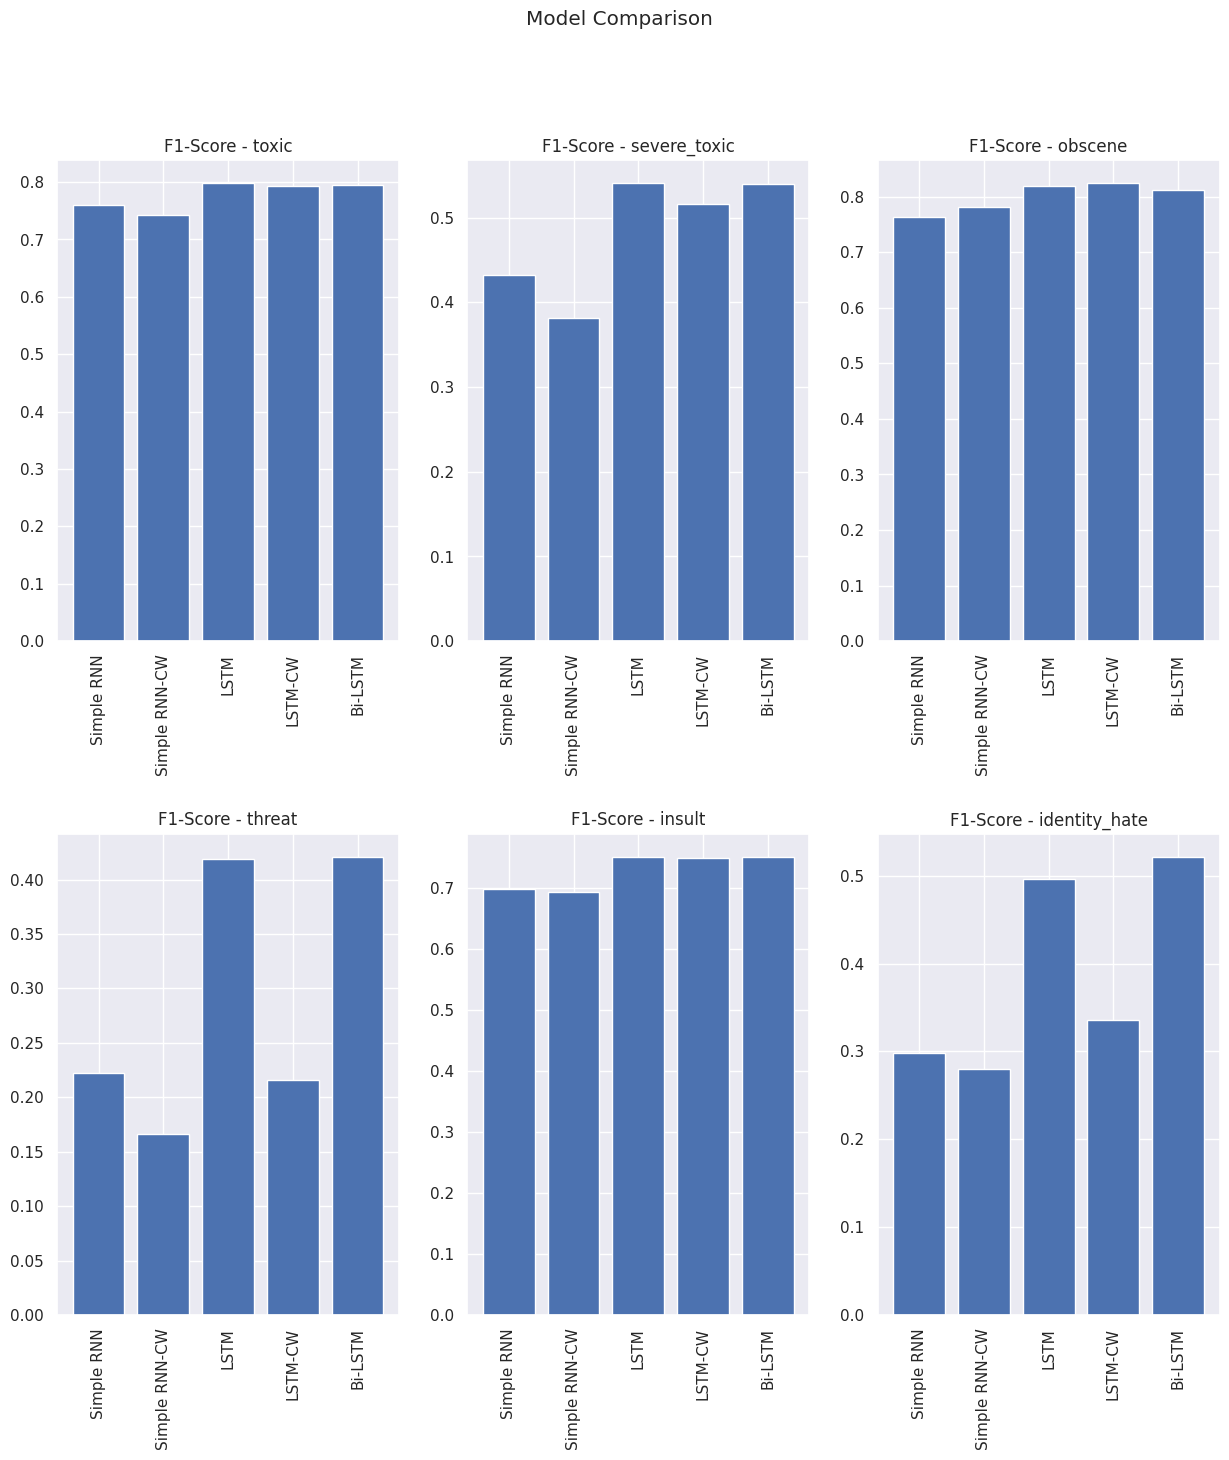

In [ ]:
models = ['Simple RNN', 'Simple RNN-CW', 'LSTM', 'LSTM-CW', 'Bi-LSTM']


plt.figure(figsize = (15,15))
sns.set_theme()
plt.subplots_adjust(hspace = 0.4)
plt.subplot(2,3,1)
plt.bar(x = models, height=f1_score_0)
plt.xticks(rotation = 90)
plt.title('F1-Score - toxic')

plt.subplot(2,3,2)
plt.bar(x = models, height=f1_score_1)
plt.xticks(rotation = 90)
plt.title('F1-Score - severe_toxic')

plt.subplot(2,3,3)
plt.bar(x = models, height=f1_score_2)
plt.xticks(rotation = 90)
plt.title('F1-Score - obscene')

plt.subplot(2,3,4)
plt.bar(x = models, height=f1_score_3)
plt.xticks(rotation = 90)
plt.title('F1-Score - threat')

plt.subplot(2,3,5)
plt.bar(x = models, height=f1_score_4)
plt.xticks(rotation = 90)
plt.title('F1-Score - insult')

plt.subplot(2,3,6)
plt.bar(x = models, height=f1_score_5)
plt.xticks(rotation = 90)
plt.title('F1-Score - identity_hate')

plt.suptitle('Model Comparison')
plt.show()

Si osserva che per le classi *toxic, obscene e insult*, che sono le più rappresentate, tutti i modelli raggiungono discreti risultati con picchi intorno a 0,8 o superiori per i modelli più complessi (LSTM e Bi-LSTM). Emerge un'importante differenza nelle classi meno frequenti (*severe_toxic, threat e indentity_hate*) dove solo i modelli più complessi e senza Class Weight riescono a ottenere risultati nettamente migliori degli altri, sebbene non soddisfacenti.

###Scelta e valutazione del modello

Dal confronto delle prestazioni ottenute dai vari modelli si è deciso di utilizzare il modello biLSTM_1, costituito da due layer LSTM bidirezionali come descritto in precedenza, utilizzando per la classificazione le soglie ottimizzate sul Validation Set.

In questa sezione questo sarà testato e valutato sul Test Set estratto inizialmente.

In [ ]:
best_th_biLSTM_1

[0.5979966, 0.38797346, 0.33400393, 0.5126811, 0.44698578, 0.6110133]

In [ ]:
y_pred_raw = biLSTM_1.predict(test_sequences_padded)
y_pred_test = get_prediction(y_pred_raw, th = [0.5979966, 0.38797346, 0.33400393, 0.5126811, 0.44698578, 0.6110133])

250/250 [==============================] - 43s 172ms/step


CLASSIFICATION REPORT: 

              precision    recall  f1-score   support

           0       0.86      0.76      0.81       756
           1       0.45      0.64      0.53        84
           2       0.77      0.89      0.83       419
           3       0.31      0.24      0.27        17
           4       0.72      0.79      0.75       397
           5       0.56      0.36      0.44        77

   micro avg       0.76      0.77      0.77      1750
   macro avg       0.61      0.61      0.60      1750
weighted avg       0.77      0.77      0.76      1750
 samples avg       0.06      0.07      0.06      1750



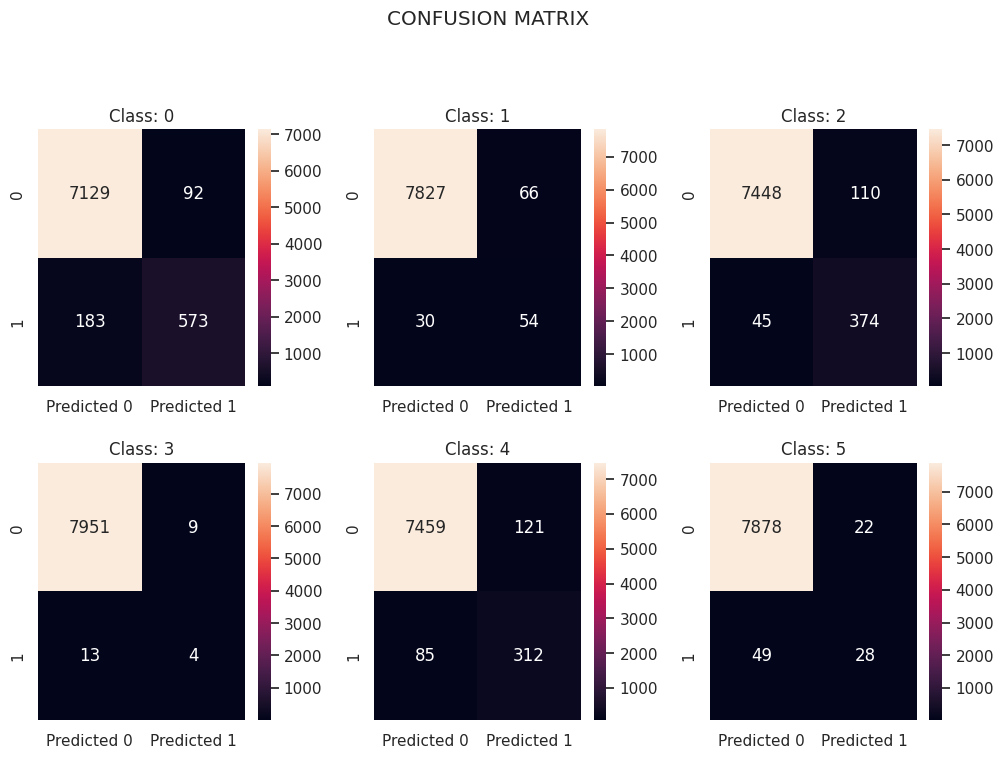

In [ ]:
evaluate_model(y_true = Y_test, y_pred = y_pred_test)

Dall'analisi del classification report e delle confusion matrix emerge che, come per il Validation Set, il modello raggiunge un F1-score di circa 0,8 per le classi più rappresentate(toxic, obscene e insult). Per quelle meno frequenti, come prevedibile, i risultati sono sensibilmente peggiori.

Globalmente i valori di F1-score per le diverse medie utilizzate sono in linea con quelli ottenuti con il Validation Set.

### Conclusioni

In conclusione, per questo progetto di classificazione multi-label di Sentiment Analysis sono stati realizzati e confrontati tra loro 5 modelli, partendo da una semplice Vanilla RNN per concludere con una rete più complessa costituita da due layer LSTM bidirezionali. Inoltre, sono stati realizzati modelli con la stessa architettura ma con parametri di addestranento differenti per tentare di risolvere il problema di sbilanciamento del dataset.

Il modello più complesso è risultato essere il migliore in termini di F1-score, metrica che si è deciso di massimizzare in quanto si è ritenuto opportuno raggiungere un buon compromesso tra precisione e recall.

Utilizzando il modello selezionato si sono ottenuti discreti risultati sul Test Set per le classi più rappresentate contrapposti a risultati piuttosto deludenti per le classi meno frequenti.

Uno sviluppo futuro potrebbe riguardare l'utilizzo di tecniche di oversampling per creare nuove osservazioni delle classi meno rappresentate così da aver un dataset più bilanciato.